In [1]:
import os
os.chdir("../")
# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')

import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

from config import *
from data import *
from train import *
from eval import *
from generation import *
from vital2d import *
print("using device: ", device)

Random seed set to 333
using device:  cpu


# Configuration (customizable)

In [2]:

overwrite = False
model_name = 'test_mixture_syn' 

text1 = ('No trend.',1)
text2 = ('No seasonal pattern.',1)
text3 = ('No sharp shifts.',1)
counter_text11 = ('The time series shows upward linear trend.',1)
counter_text12 = ('The time series shows downward linear trend.',1)
counter_text2 = ('The time series exhibits a seasonal pattern.',1)
counter_text31 = ('The mean of the time series shifts upwards.',10)
counter_text32 = ('The mean of the time series shifts downwards.',10)


text_config = {'text_pairs': [
                    [text1, counter_text11, counter_text12],
                    [text2, counter_text2],
                    [text3, counter_text31, counter_text32]
                ],  'n': None}

attr_id = 3 # y_col by the third attribute (third element in the text_config['text_pairs'])
update_config(
    
    # Eval settings (clip)
    # ts2txt
    y_col = 'segment'+str(attr_id),
    y_levels = [t[0]for t in text_config['text_pairs'][attr_id-1]],
    y_pred_levels =[t[0]for t in text_config['text_pairs'][attr_id-1]],
    # txt2ts
    txt2ts_y_cols = ['segment1', 'segment2', 'segment3'],
    
    
    # Data settings
    text_col = 'text', #'ts_description',
    seq_length = 200,
    downsample = True,
    downsample_size = 500,
    downsample_levels = [t[0]for t in text_config['text_pairs'][attr_id-1]],
    custom_target_cols = ['segment1', 'segment2', 'segment3', 'label'], # 'label' is the same as the default "by_label" target
    
    
    # Model settings
    model_name = model_name,
    **{'3d': False},  # Add this line
    embedded_dim = 512,
    concat_embeddings = False,
    clip_mu = False,
    variational = False,
    train_type = 'joint', # or 'vae', 'clip'
    clip_target_type = 'by_target', # or 'by_label'
    
    # Train settings
    batch_size = 512,
    init_lr = 1e-4,
    patience = 100,
    alpha = 1/100,
    num_saves = 5,
    num_epochs = 500,
    
    # Text configuration
    text_config = text_config
)
config_dict = get_config_dict()



# Data

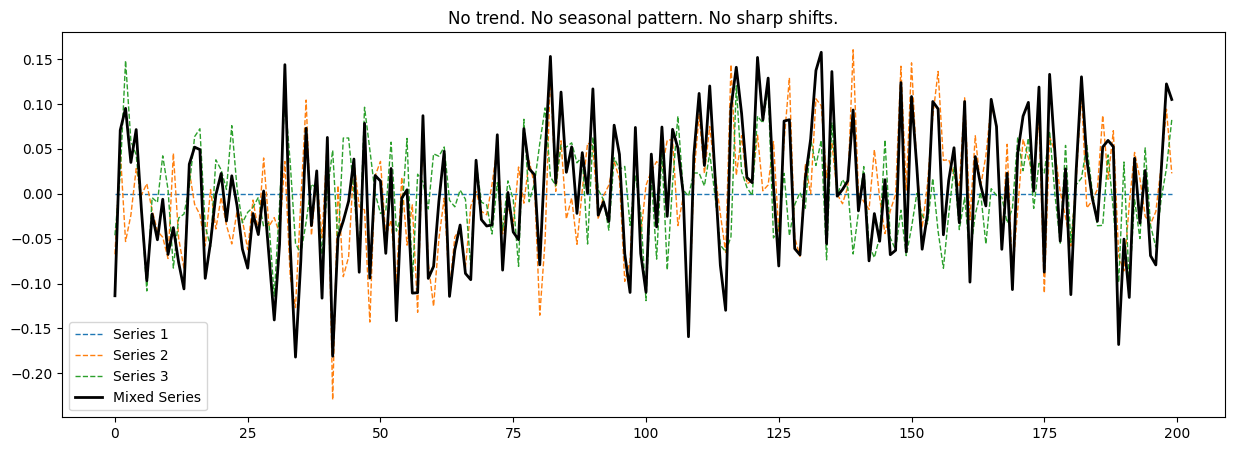

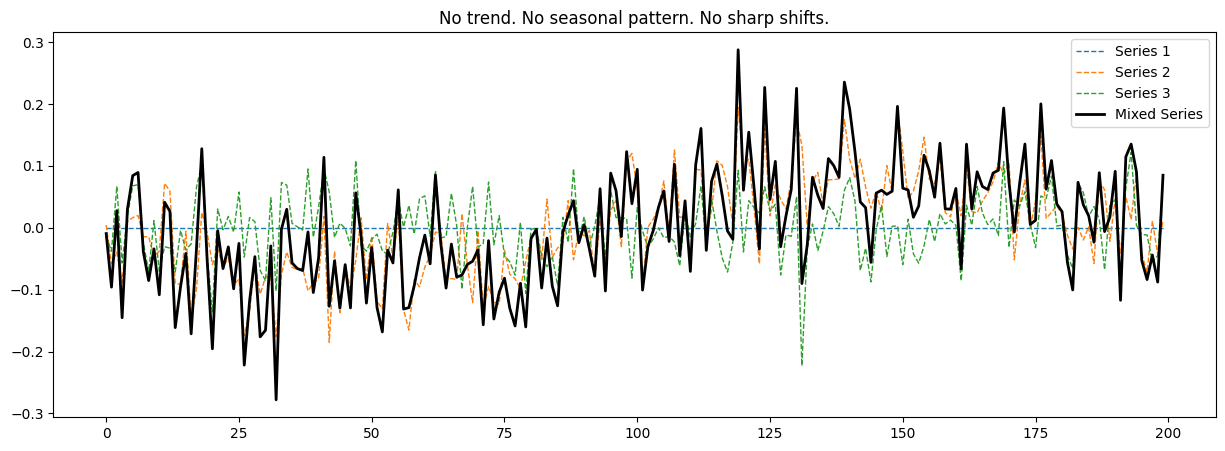

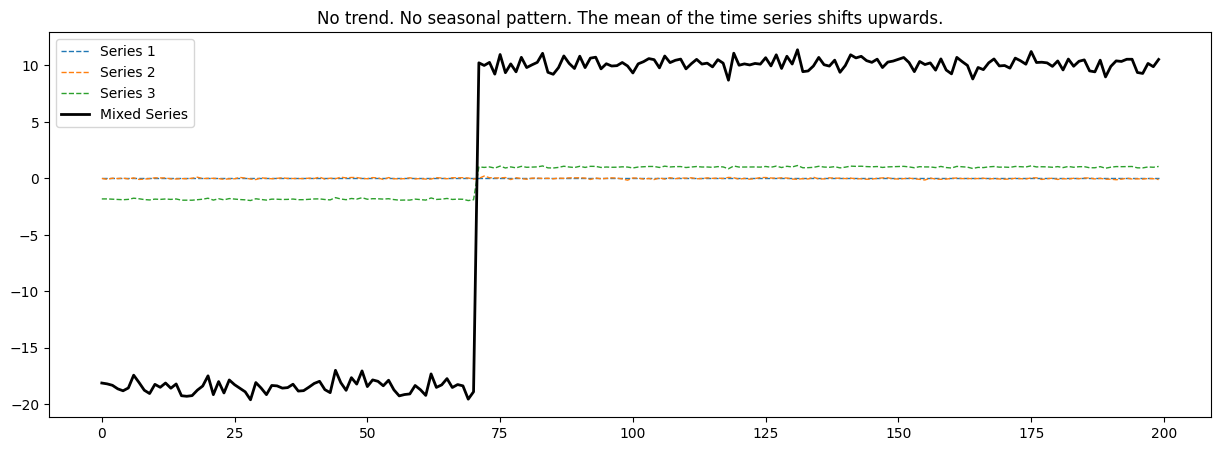

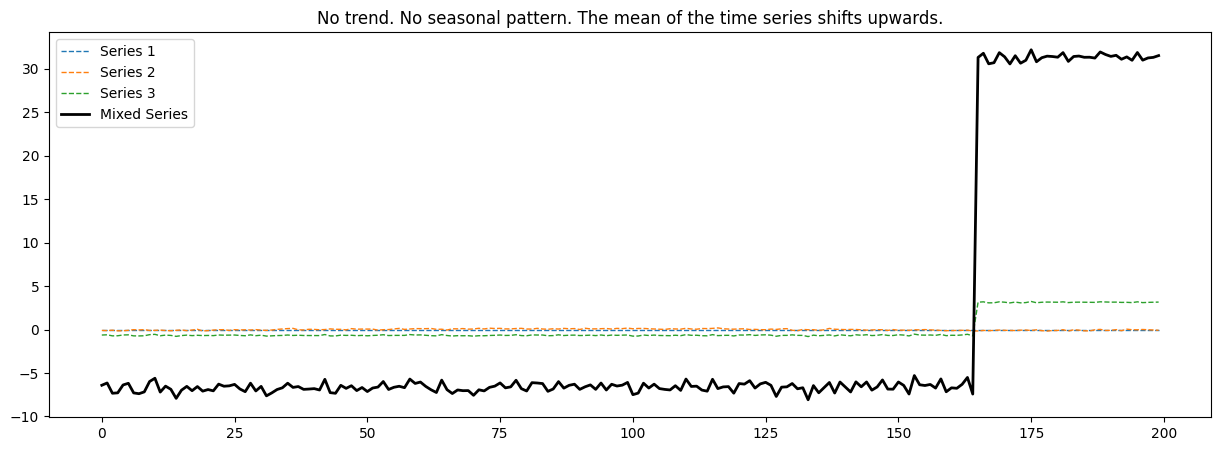

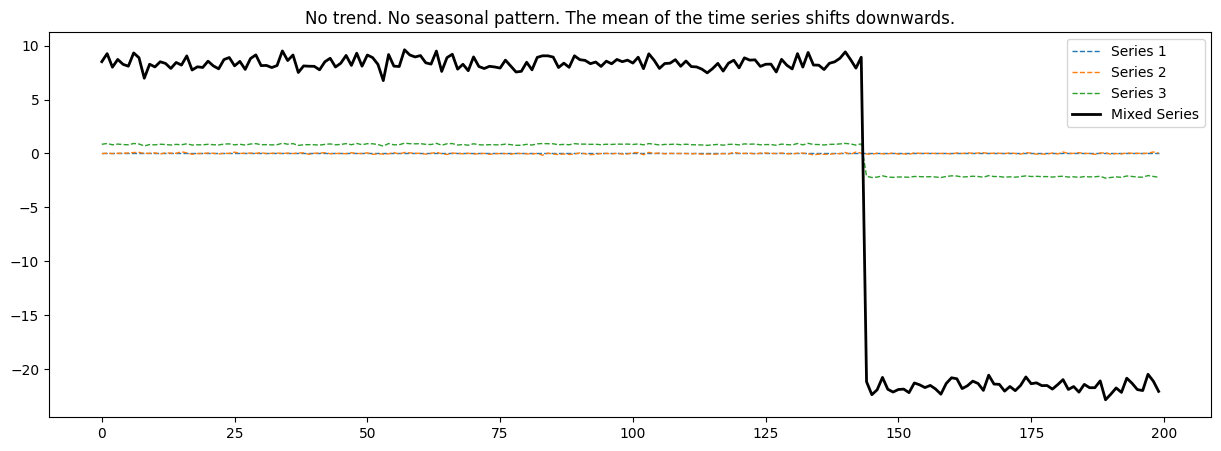

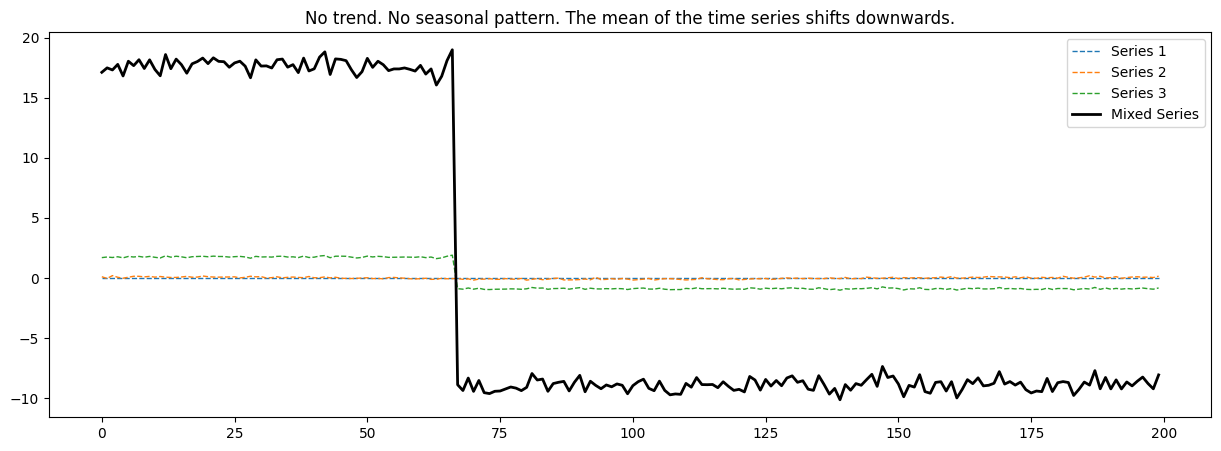

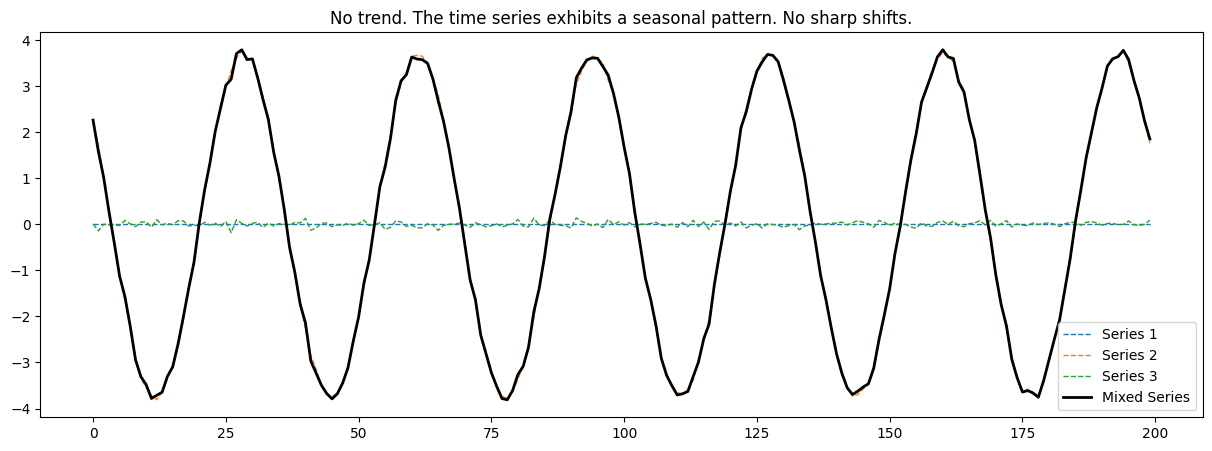

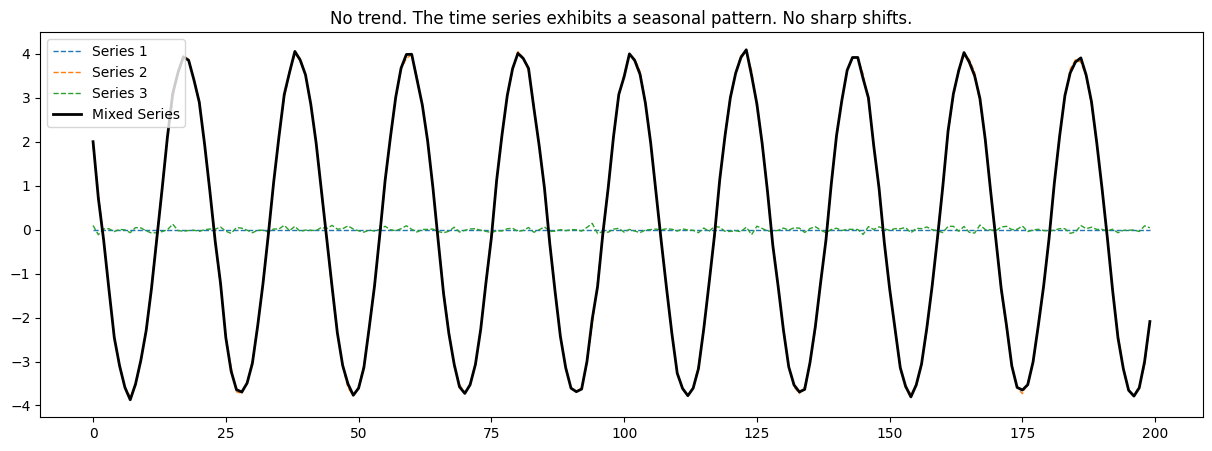

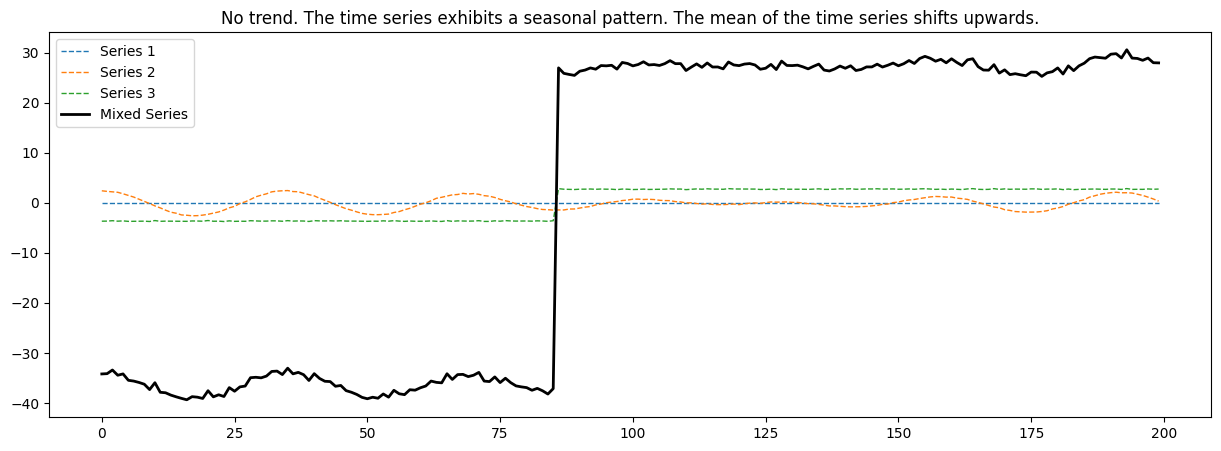

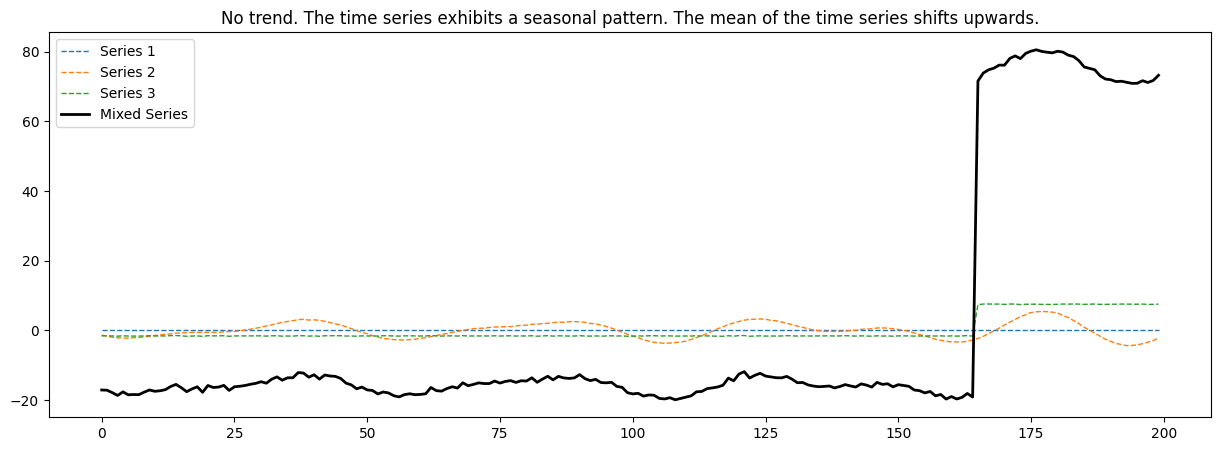

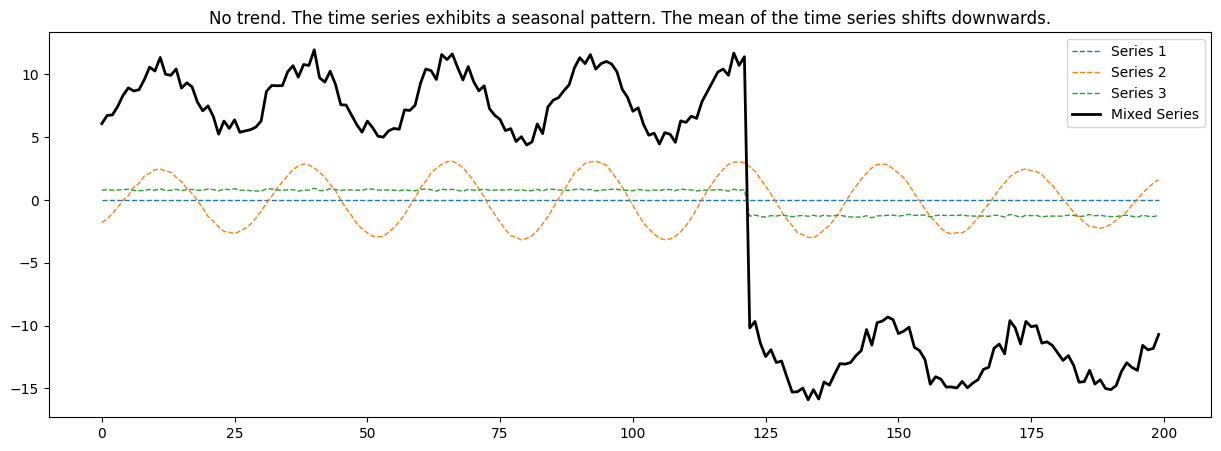

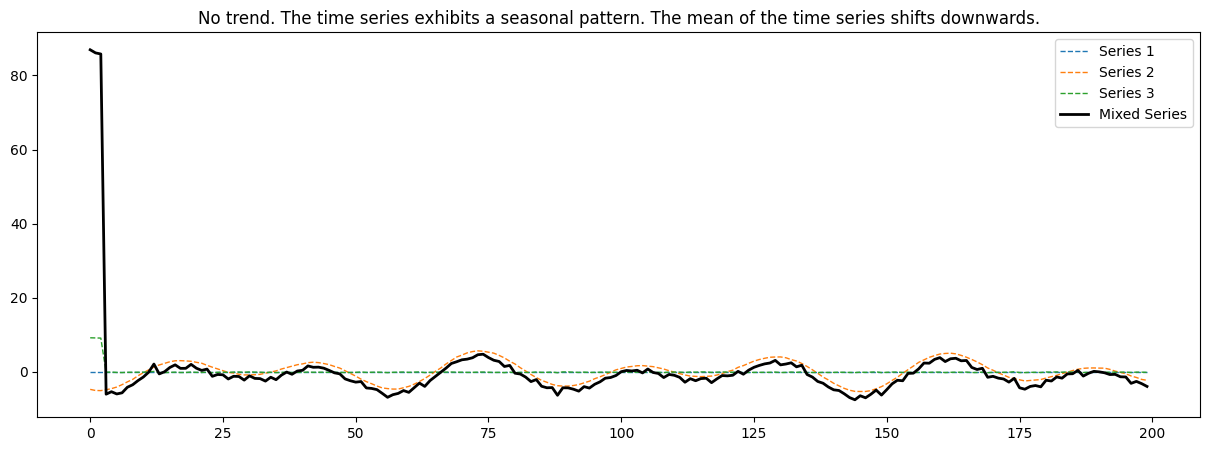

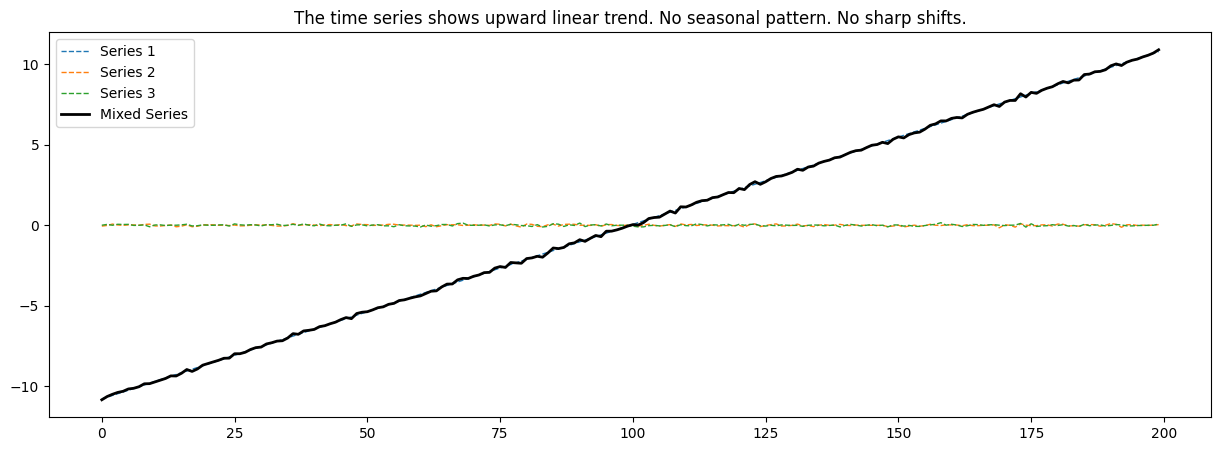

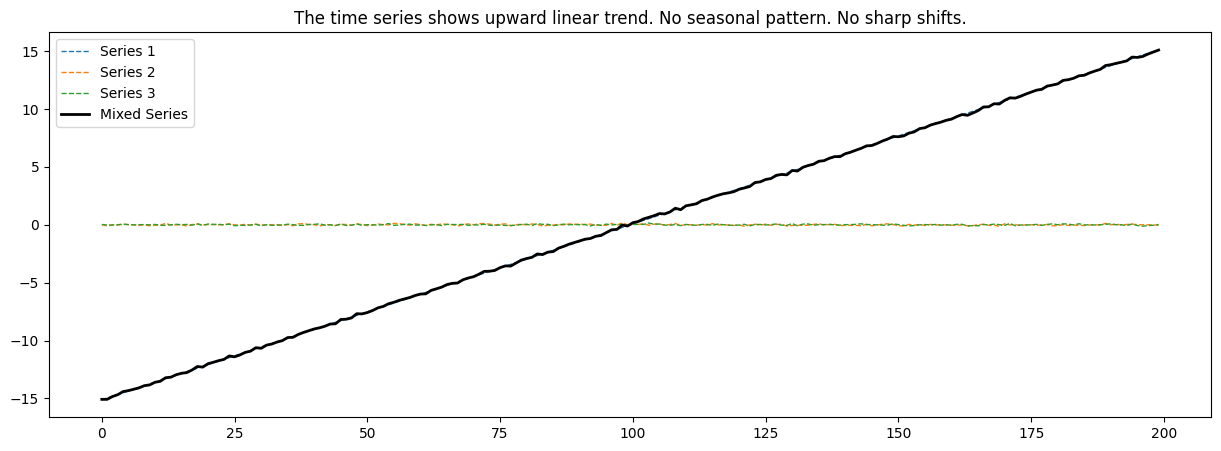

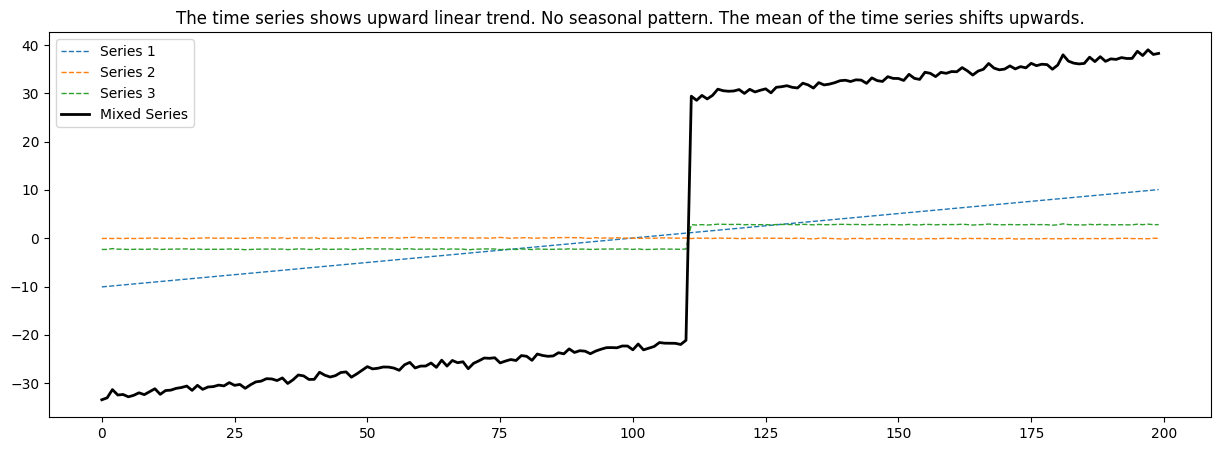

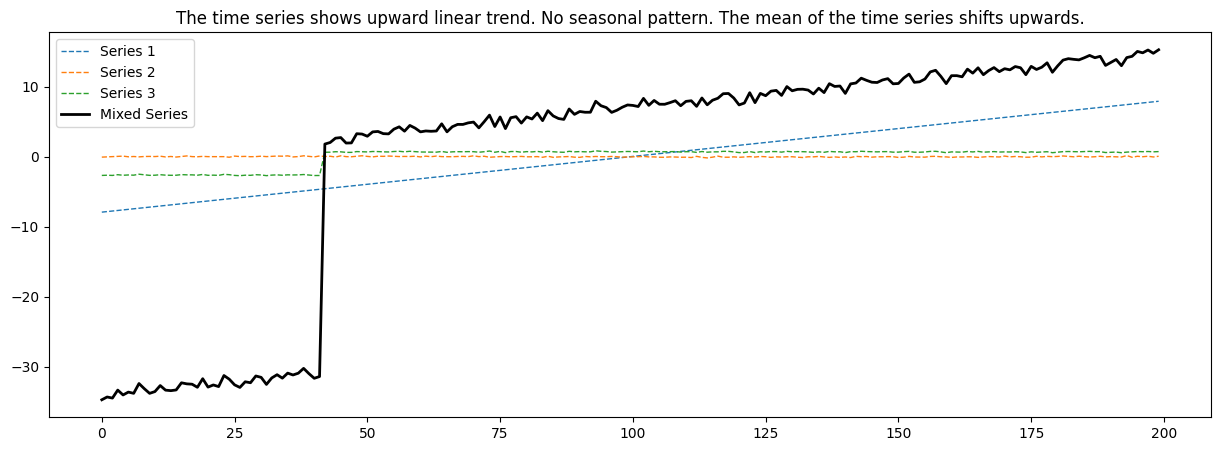

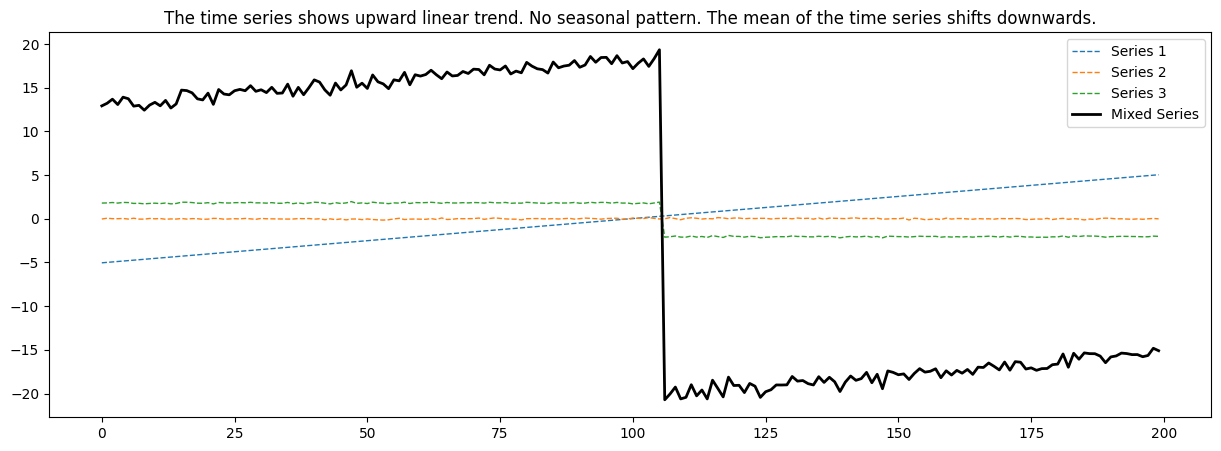

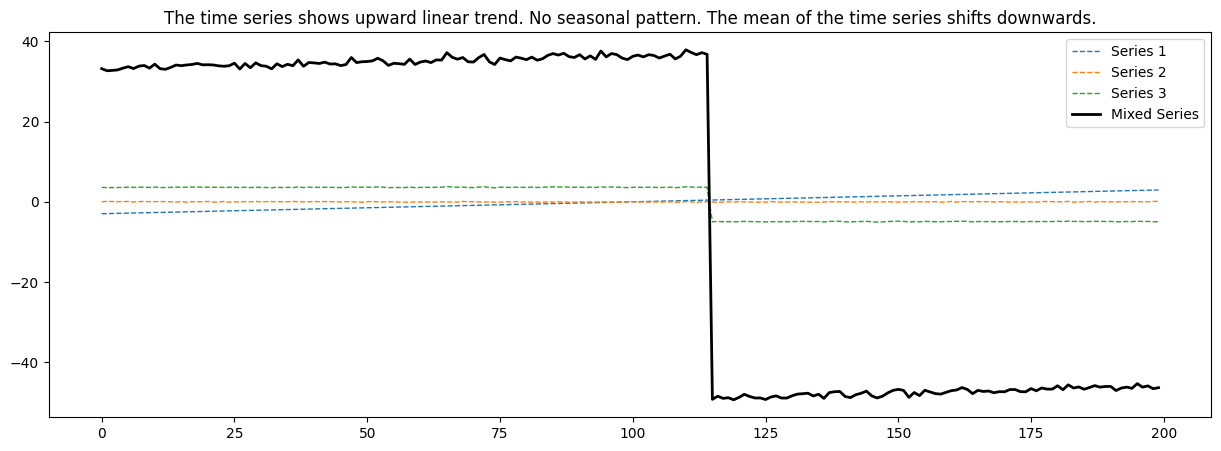

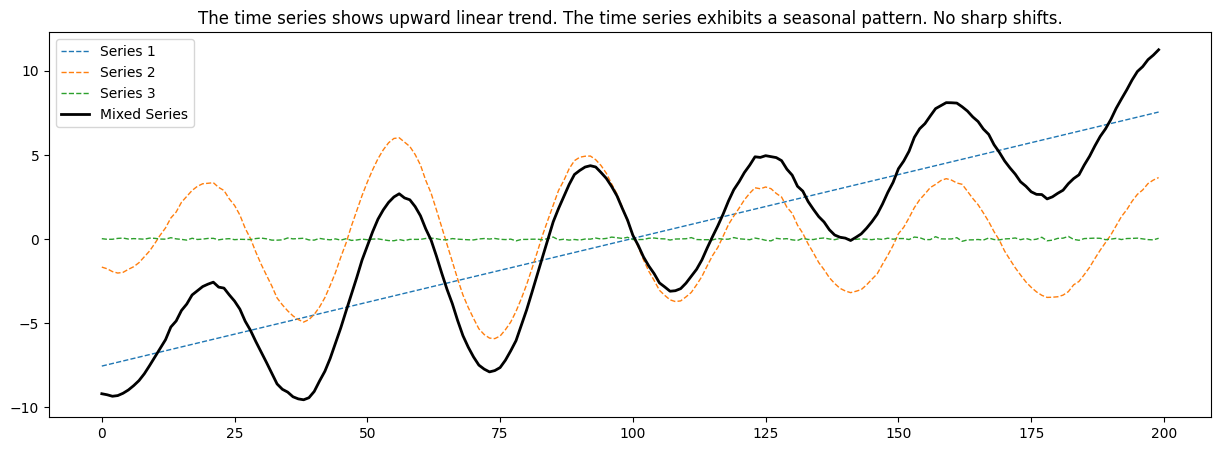

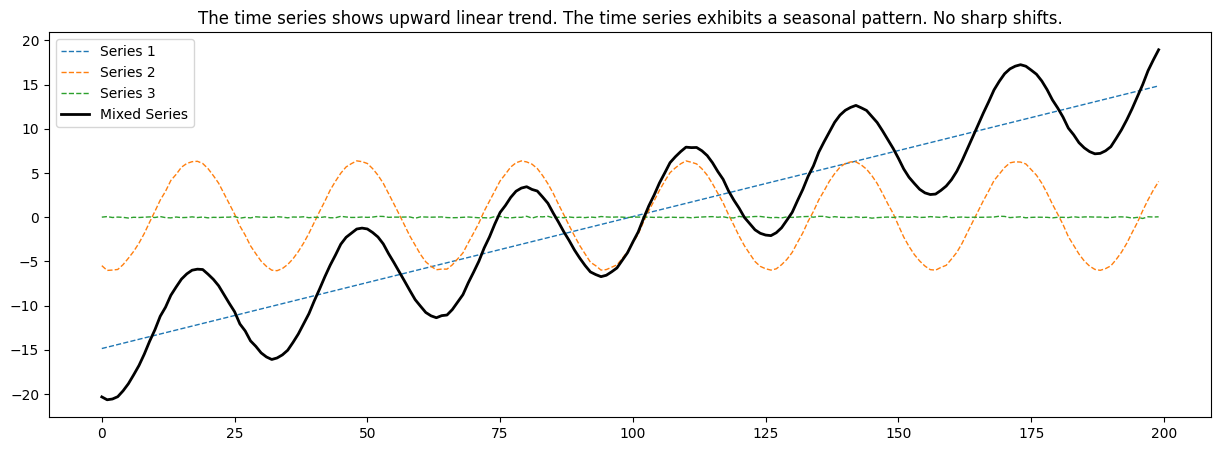

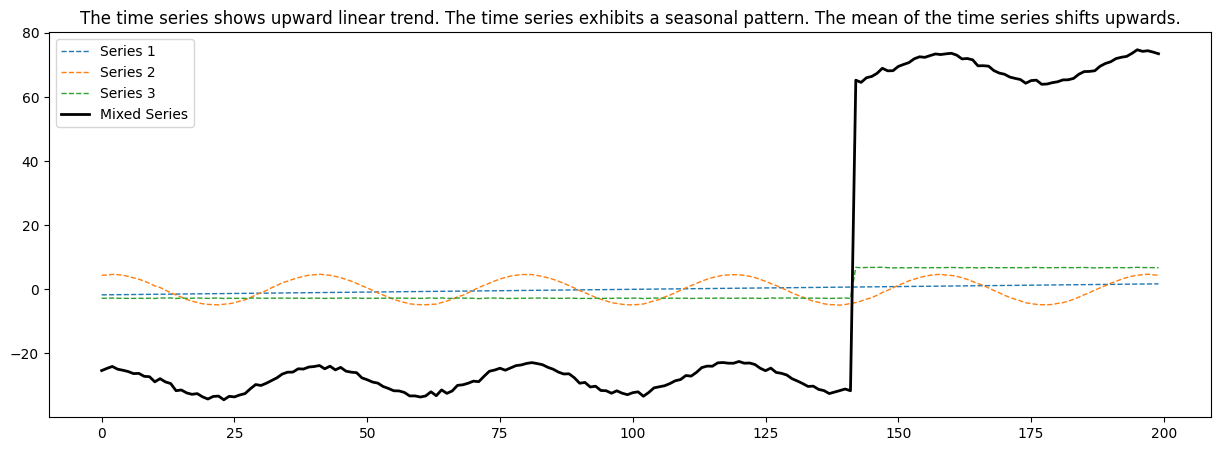

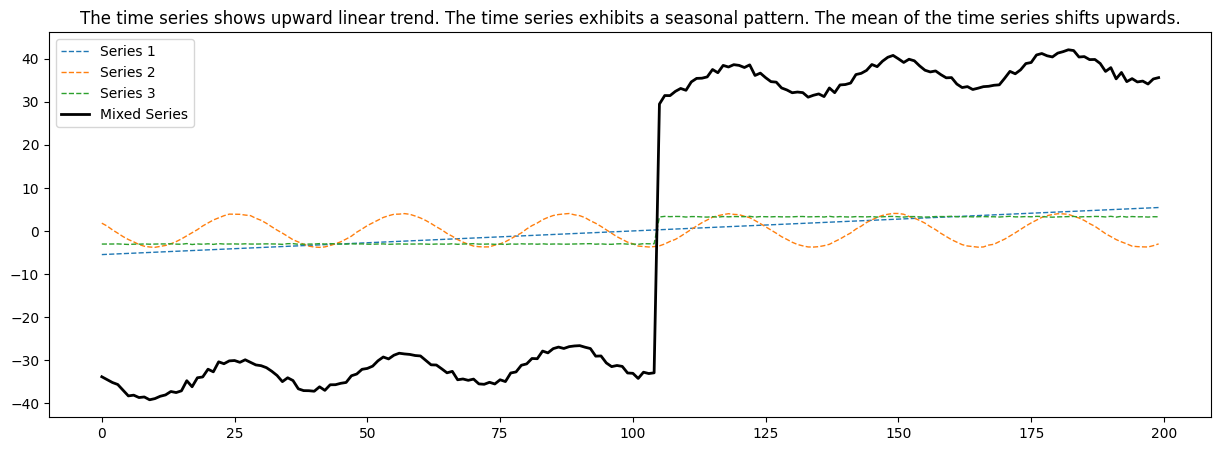

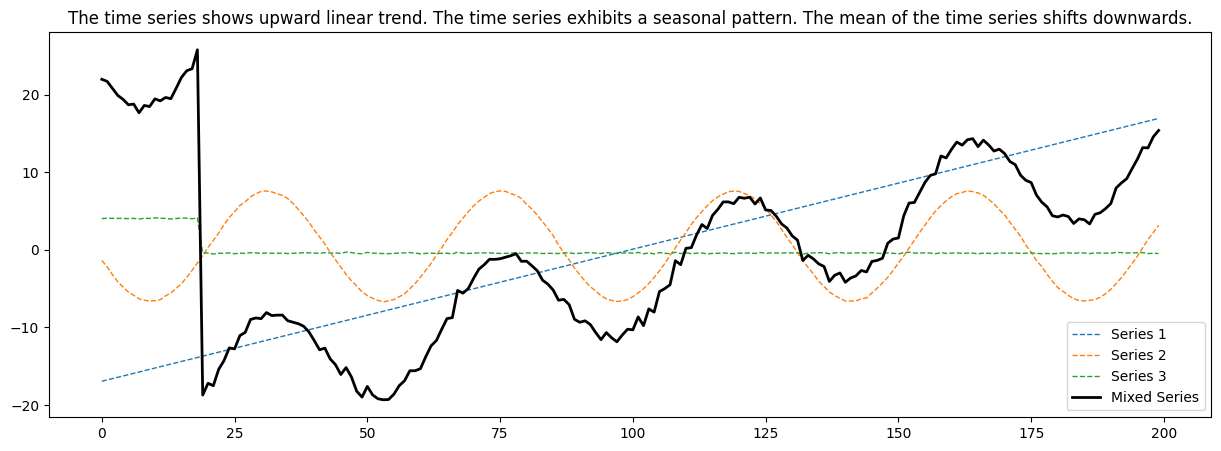

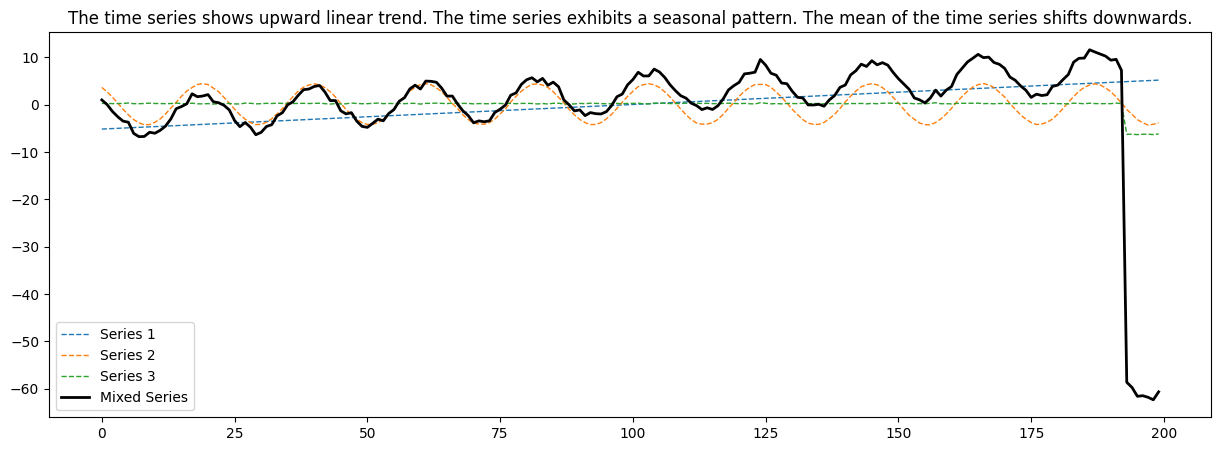

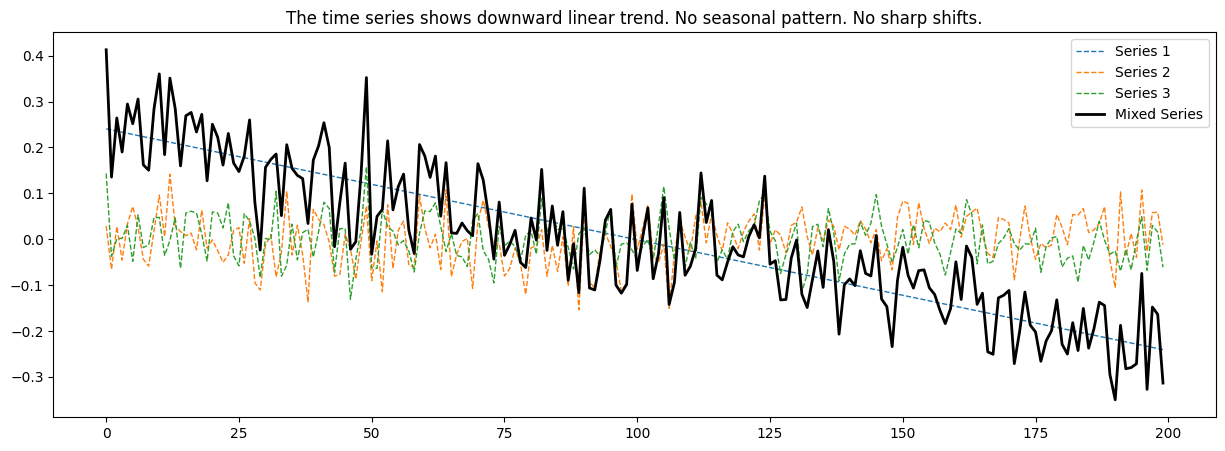

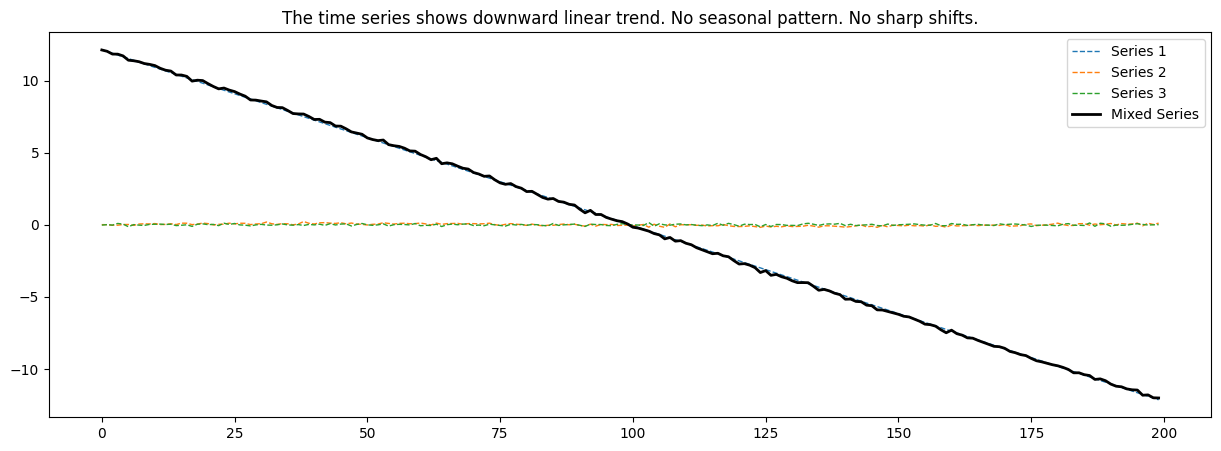

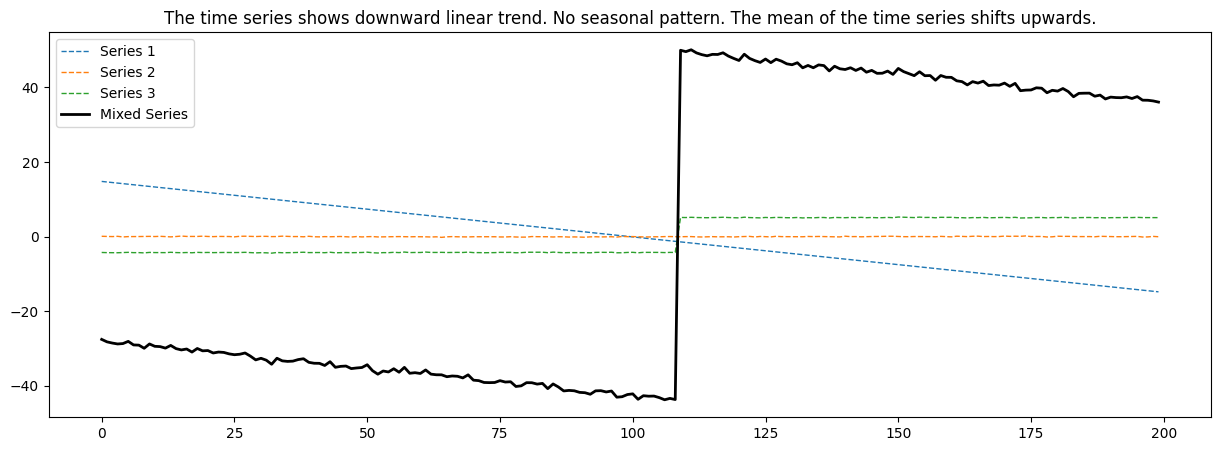

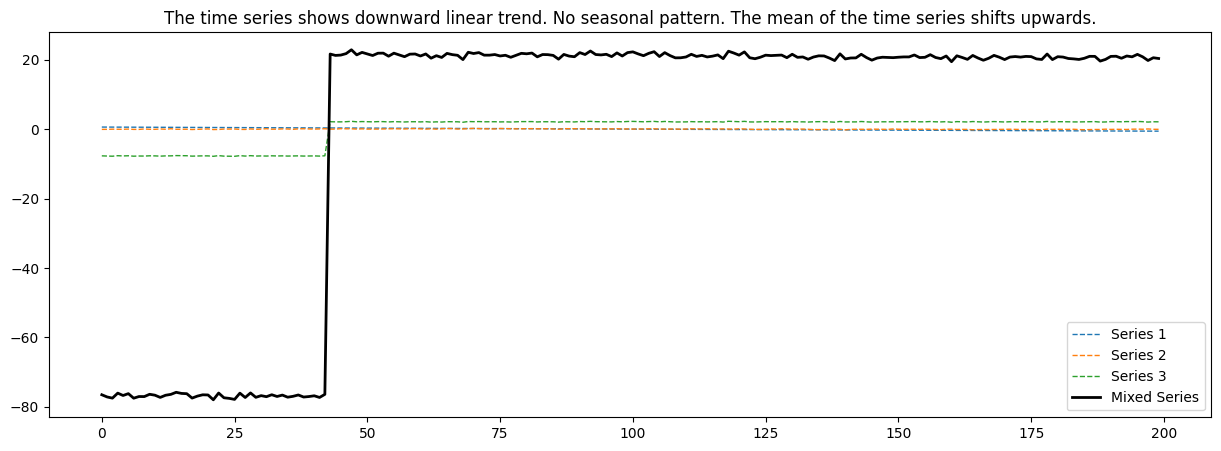

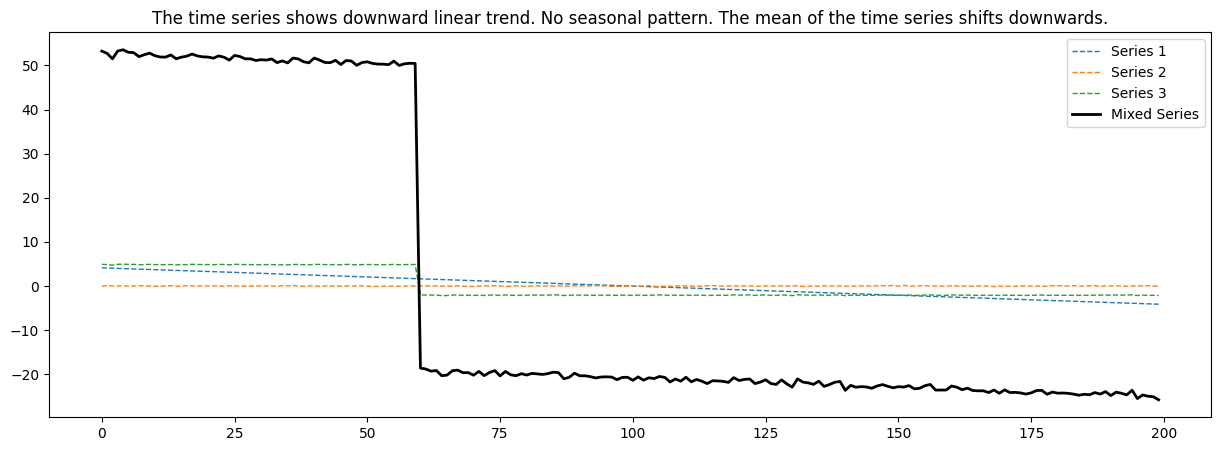

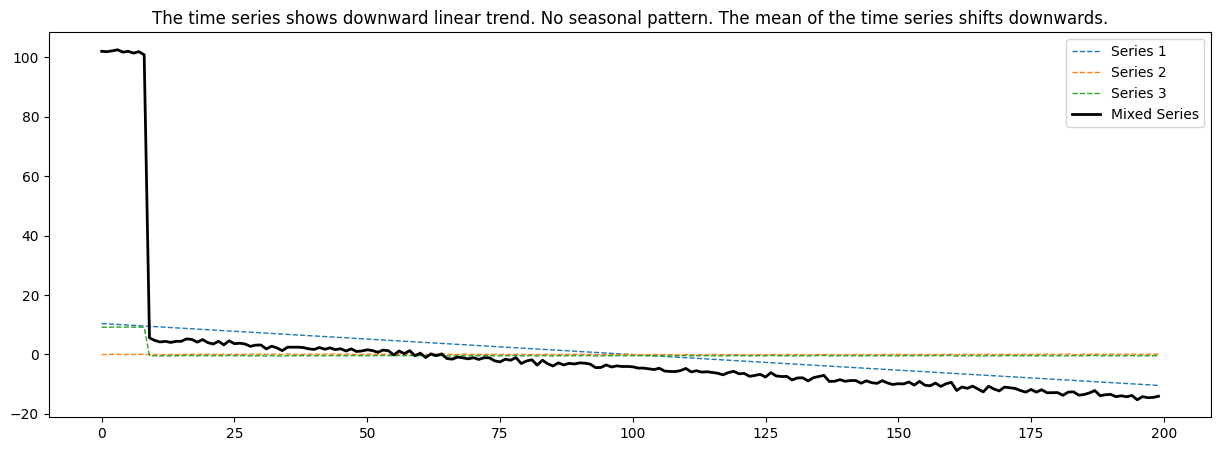

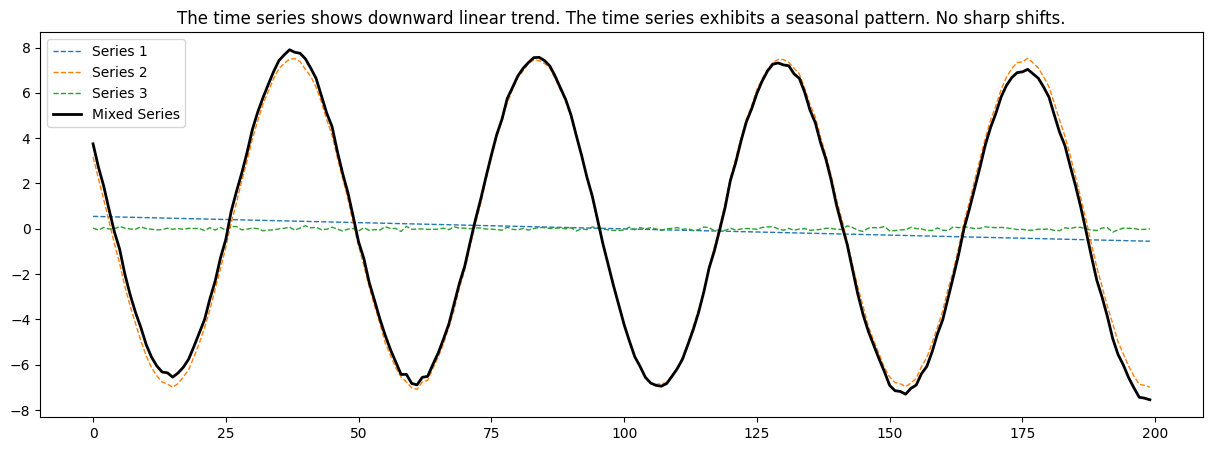

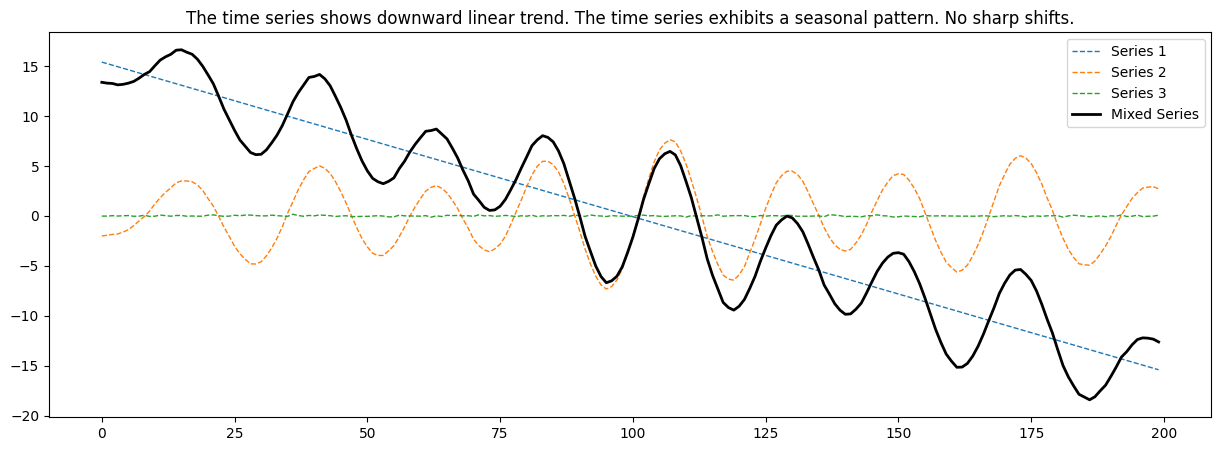

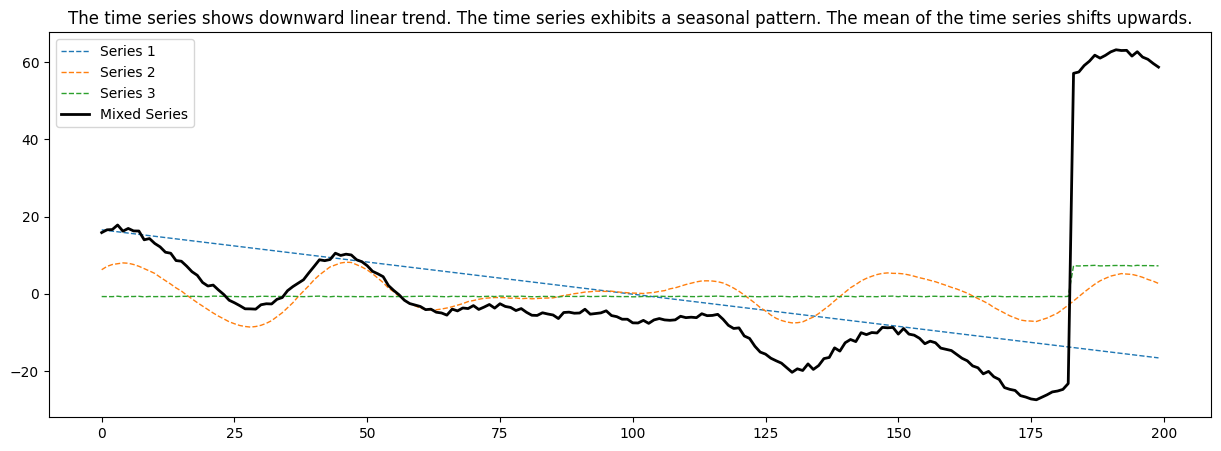

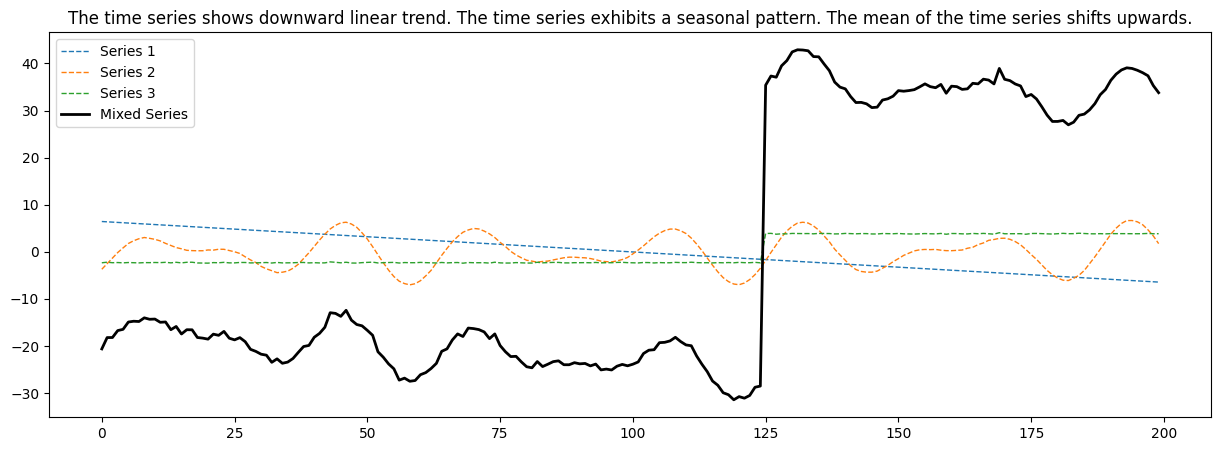

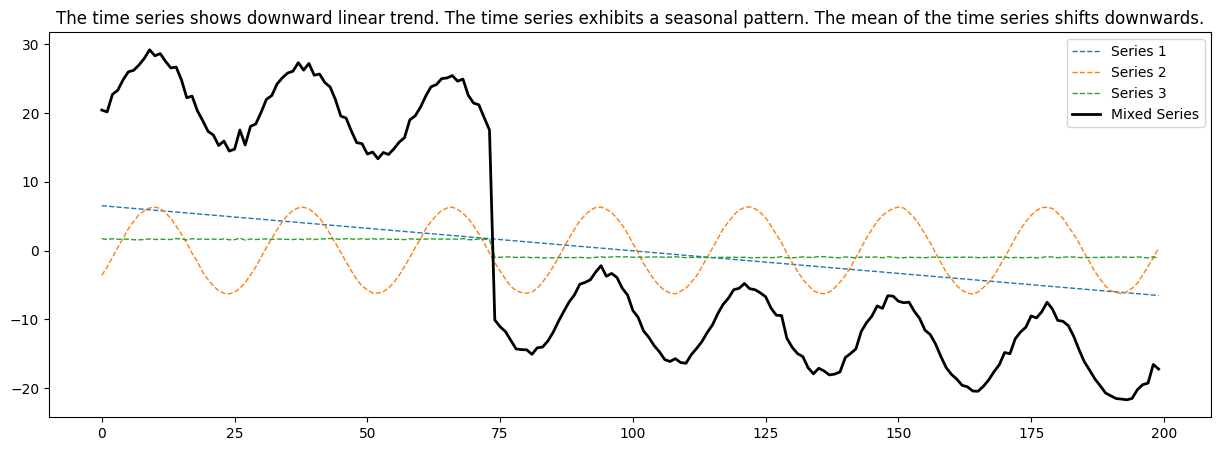

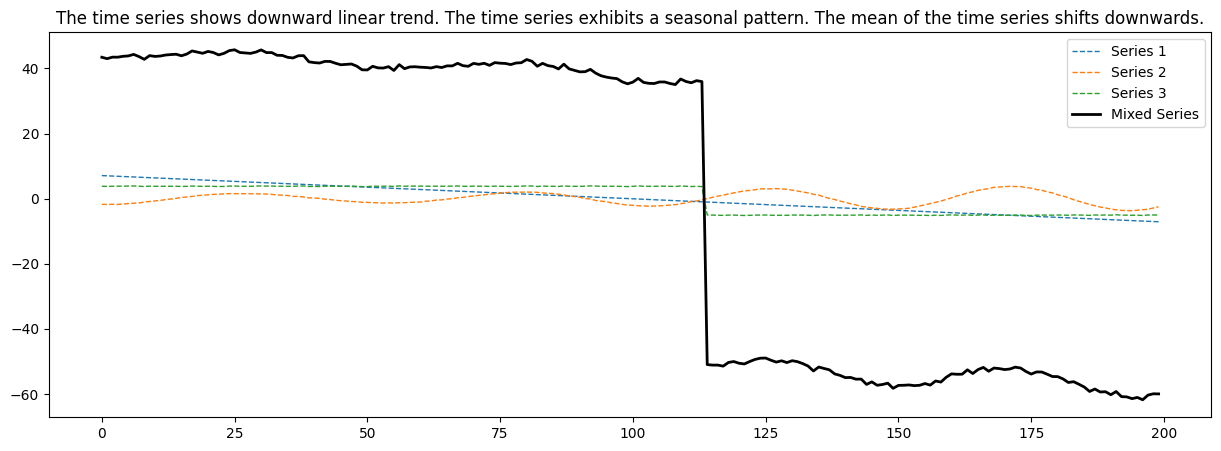

text
No trend. No seasonal pattern. No sharp shifts.                                                                                            10000
No trend. No seasonal pattern. The mean of the time series shifts upwards.                                                                 10000
The time series shows downward linear trend. The time series exhibits a seasonal pattern. The mean of the time series shifts upwards.      10000
The time series shows downward linear trend. The time series exhibits a seasonal pattern. No sharp shifts.                                 10000
The time series shows downward linear trend. No seasonal pattern. The mean of the time series shifts downwards.                            10000
The time series shows downward linear trend. No seasonal pattern. The mean of the time series shifts upwards.                              10000
The time series shows downward linear trend. No seasonal pattern. No sharp shifts.                                           

/Users/joyqiu/Documents/Documents JoyQiu Work/Research/LLMTimeSeries/llm_nicu_vitalsigns/clip_env/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
# change data preparation for a given experiment
with open('prepare_experiment/synthetic.py', 'r') as file:
    exec(file.read())
# prepare model inputs
with open('run/inputs.py', 'r') as file:
    exec(file.read())

# Model (customizable)

In [18]:
# customize encoder and decoder here. 
ts_encoder = MultiCNNEncoder(ts_dim = ts_f_dim.shape[1],
                             output_dim=config_dict['embedded_dim'],
                             kernel_sizes=[80, 50, 20, 5],
                             hidden_num_channel=16,
                             dropout=0)
ts_decoder = TransformerDecoder(ts_dim = ts_f_dim.shape[1], output_dim = config_dict['embedded_dim']+2, 
                 nhead = 8,
                 num_layers = 6,
                 dim_feedforward = 512,
                 dropout = 0.1)
text_encoder = TextEncoderMultiCNN(text_dim = tx_f_dim.shape[1],
                                   output_dim=config_dict['embedded_dim'],
                                   kernel_sizes=[500, 250, 100],  # Different context windows
                                   hidden_num_channel=16,
                                   dropout=0.0)
# overwrite = False
with open('run/model.py', 'r') as file:
    exec(file.read())


Layer (type:depth-idx)                                                      Param #
VITAL                                                                       1
├─TSVAEEncoder: 1-1                                                         --
│    └─LocalNorm: 2-1                                                       --
│    └─MultiCNNEncoder: 2-2                                                 512
│    │    └─ModuleList: 3-1                                                 3,281,520
│    │    └─MultiheadAttention: 3-2                                         1,050,624
│    │    └─LayerNorm: 3-3                                                  1,024
│    └─Linear: 2-3                                                          262,656
│    └─Linear: 2-4                                                          262,656
├─TextEncoder: 1-2                                                          --
│    └─TextEncoderMultiCNN: 2-5                                             512
│    │    └─ModuleL

# Train

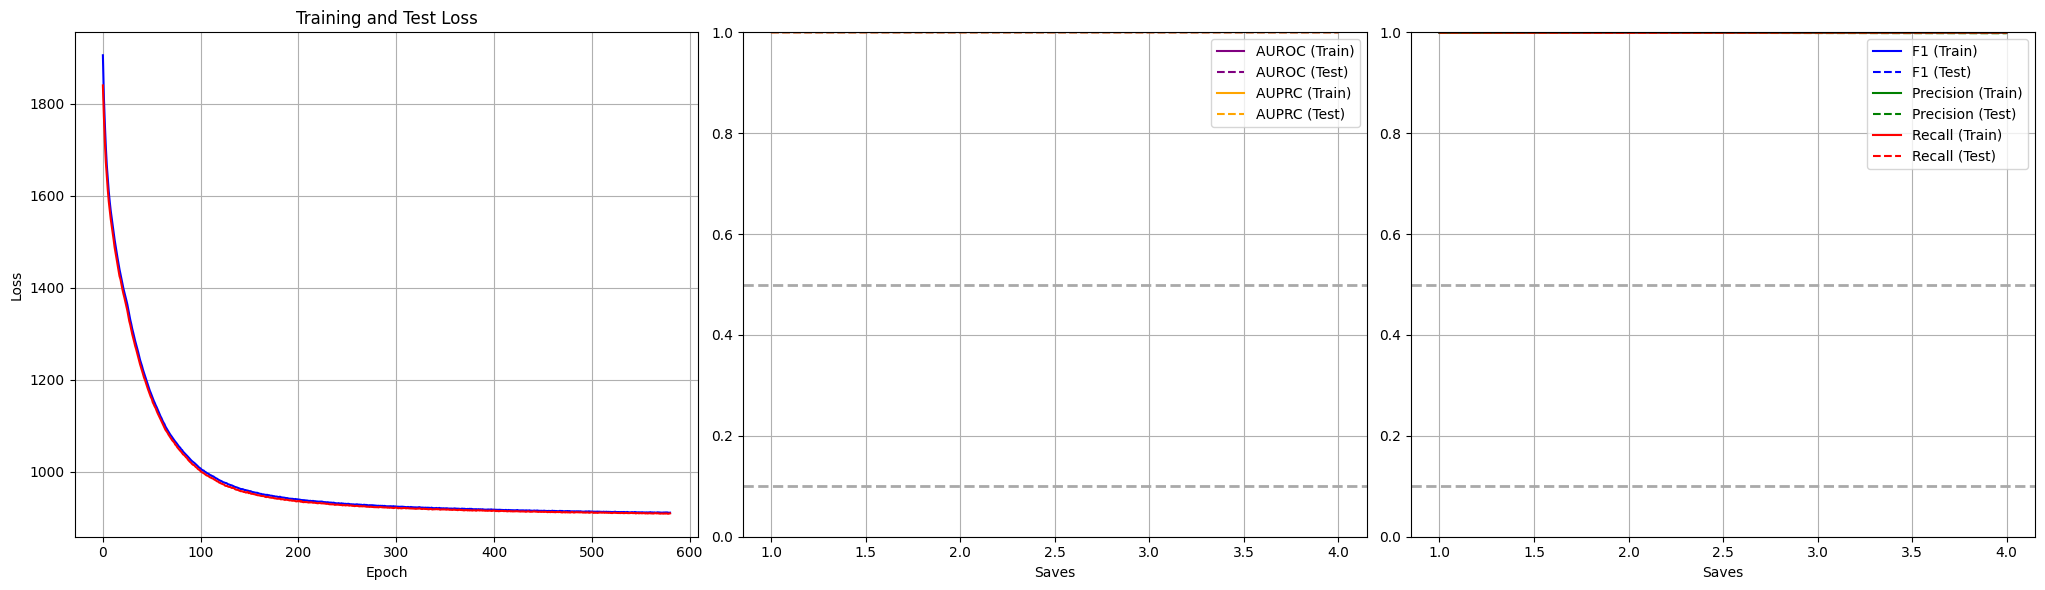

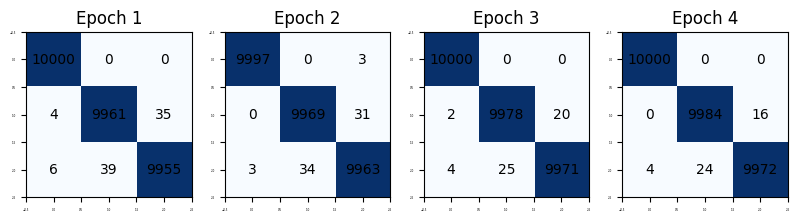

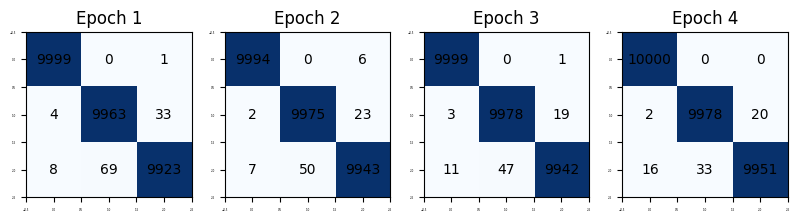

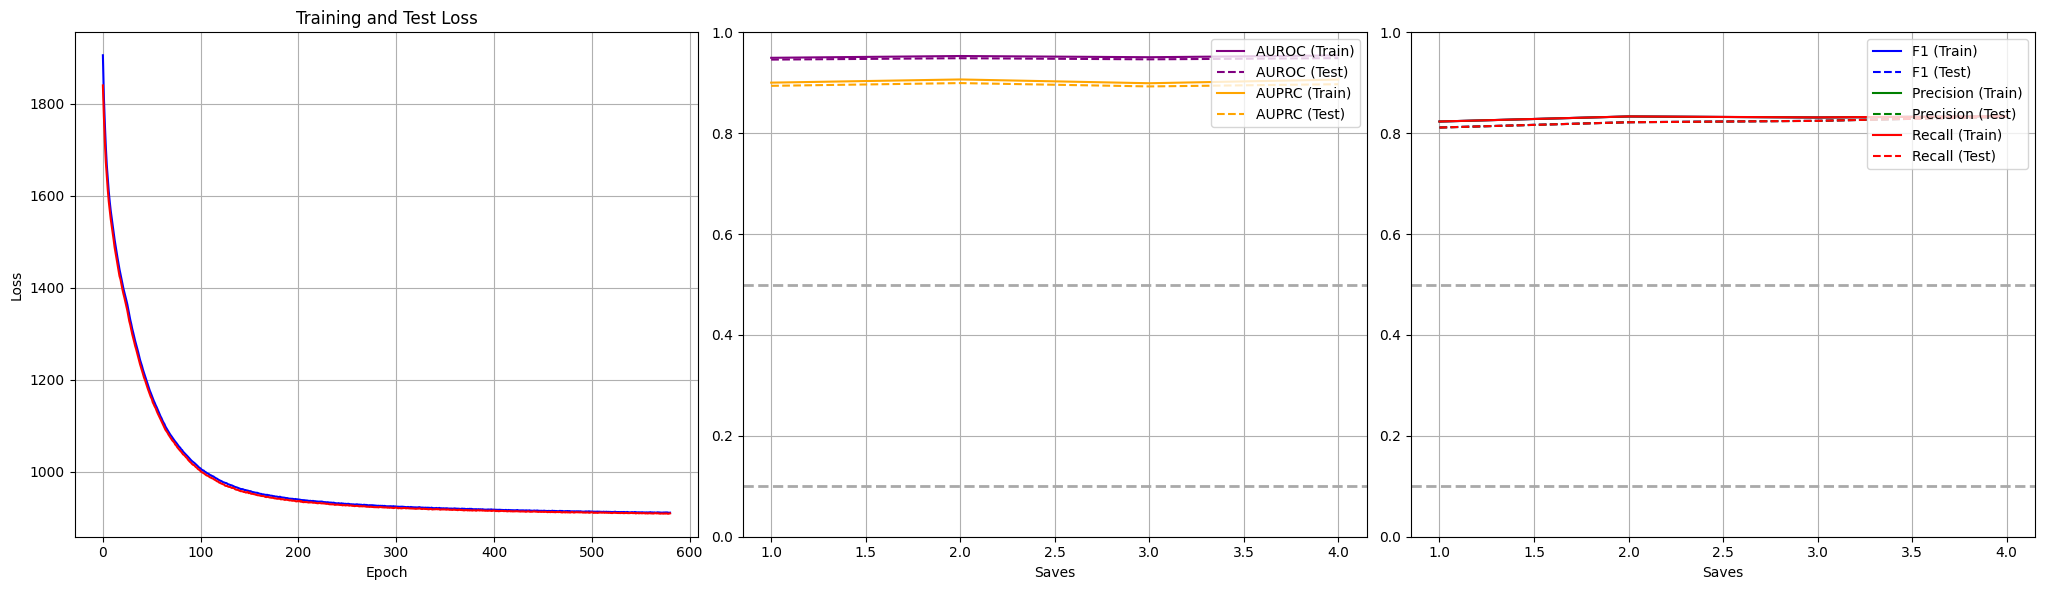

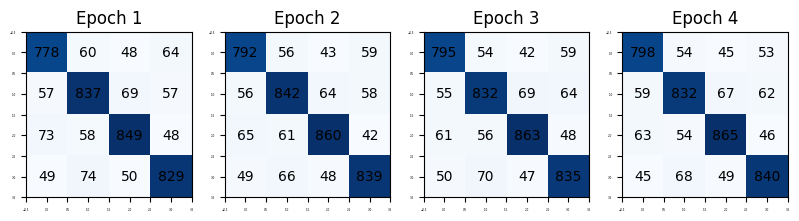

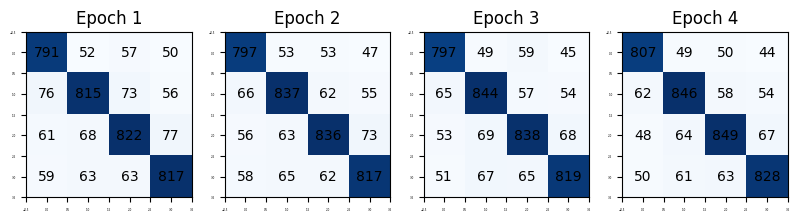

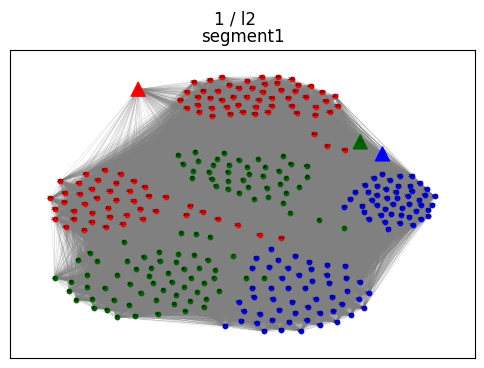

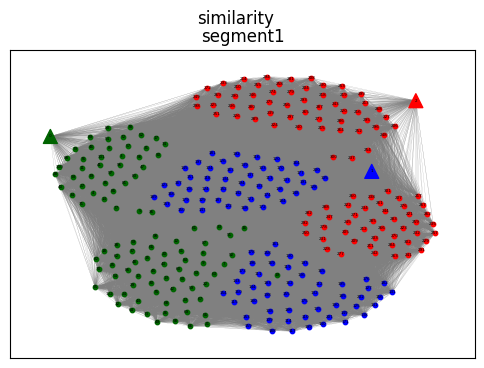

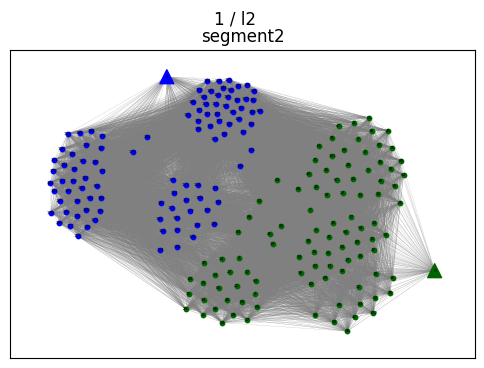

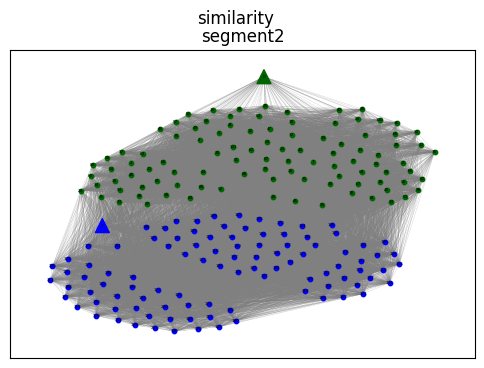

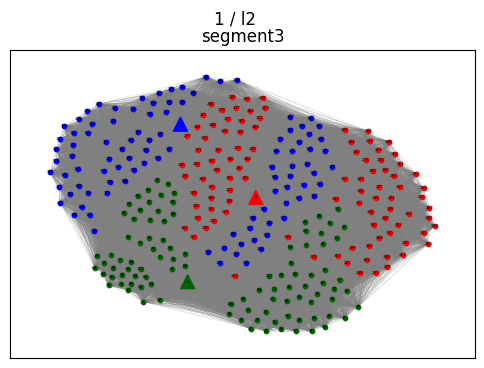

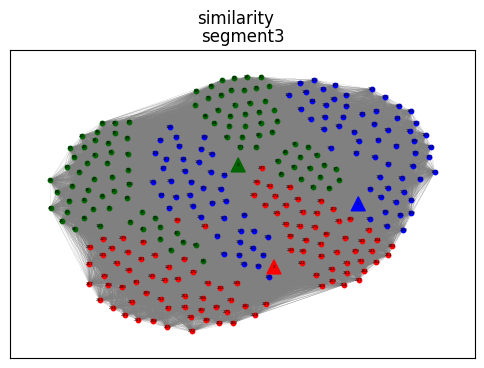

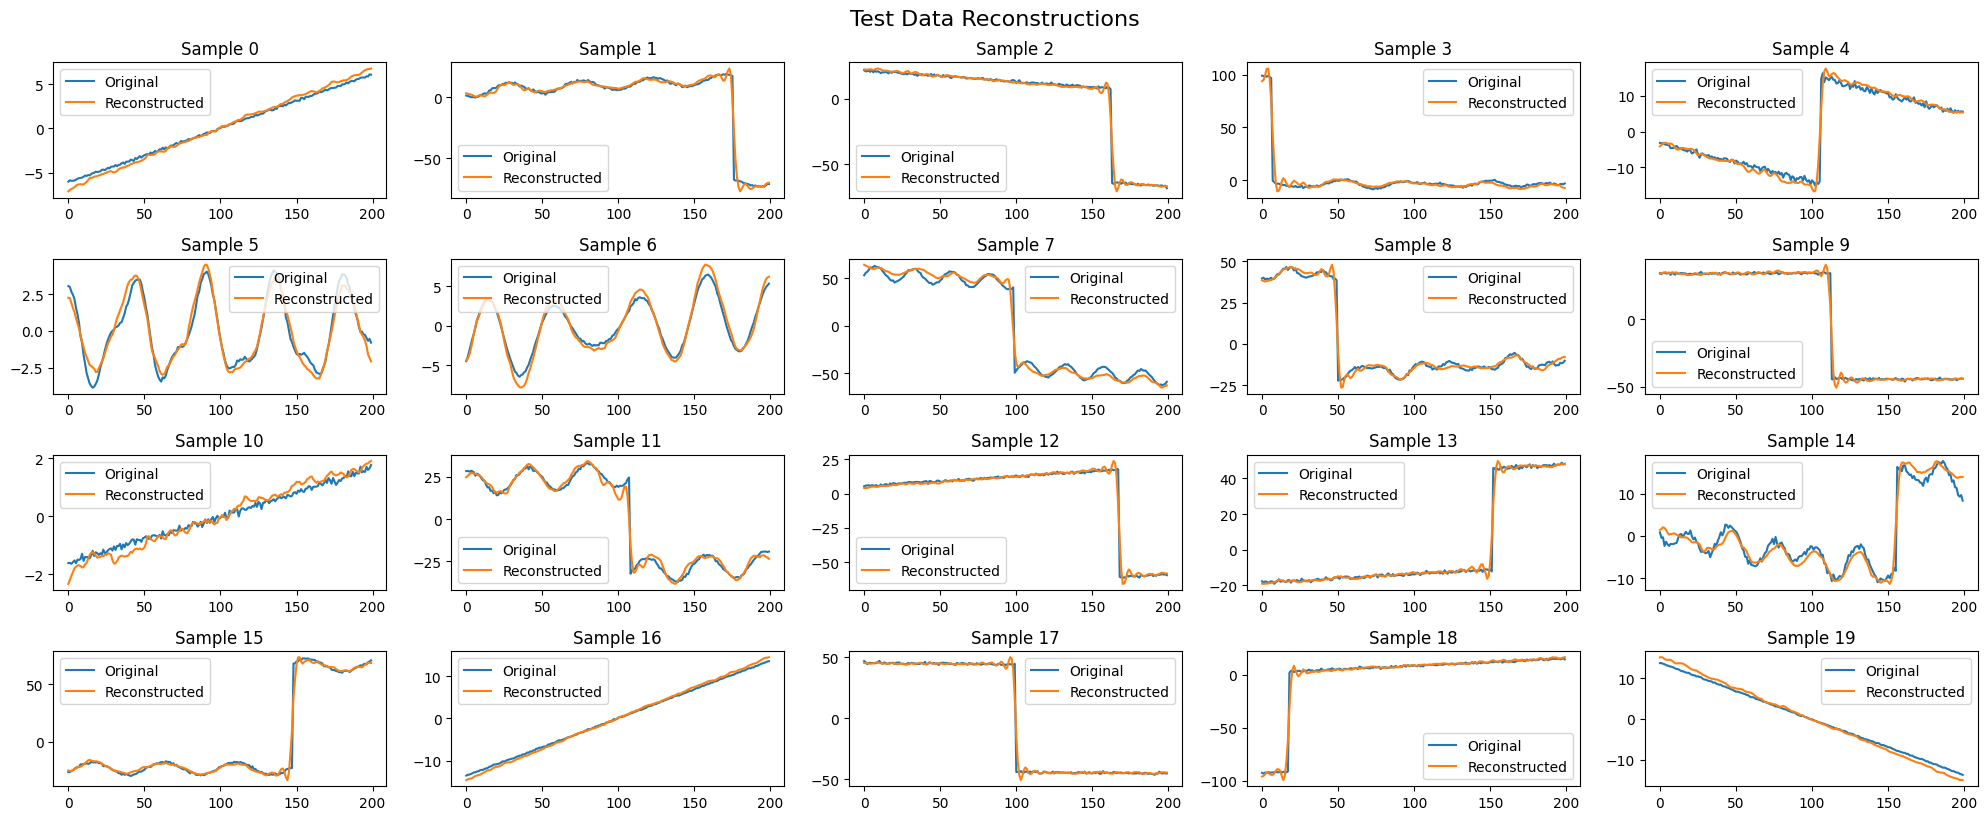

0    No trend.
Name: segment1, dtype: object


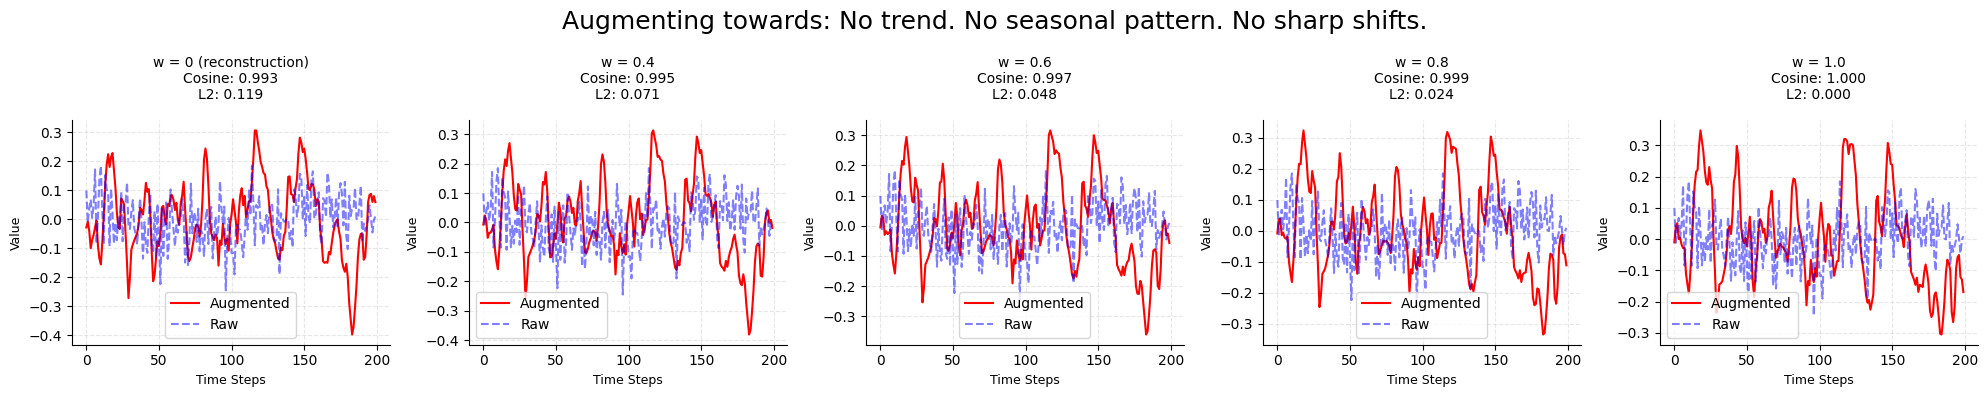

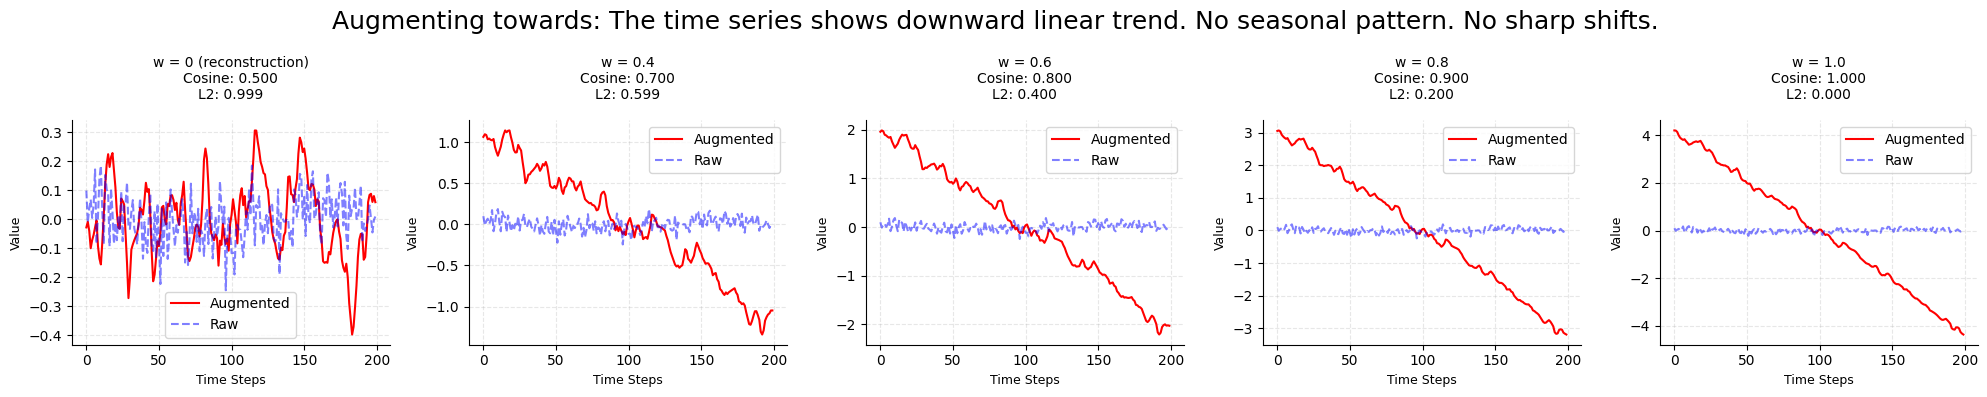

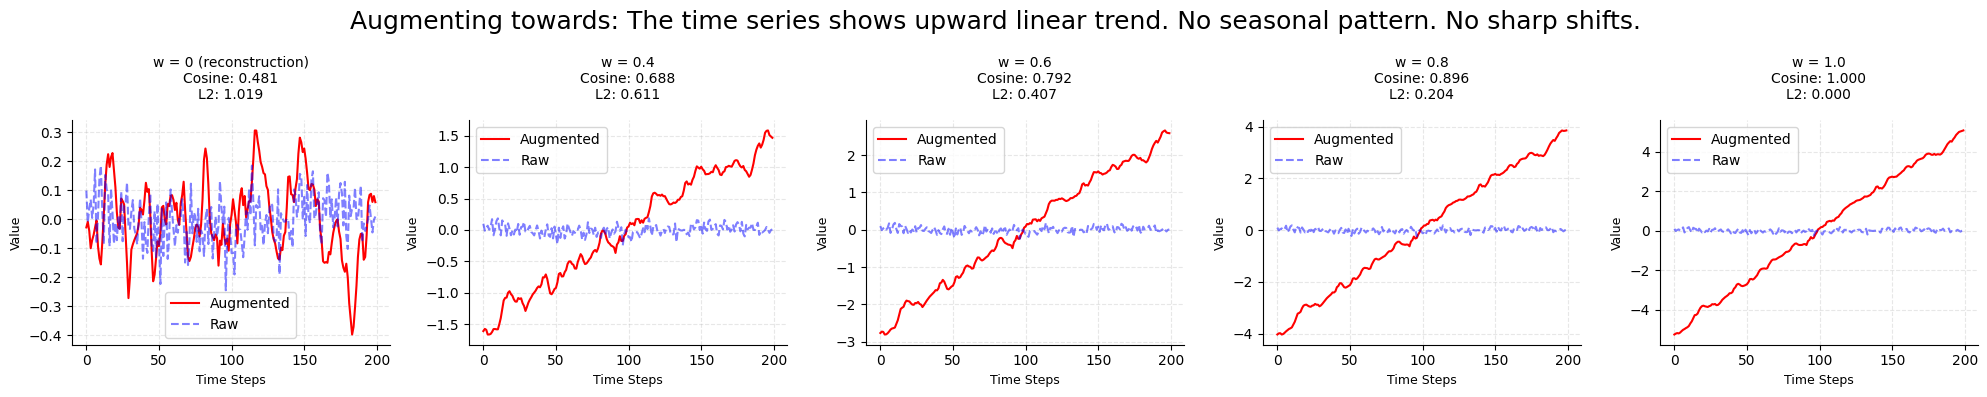

0    The time series shows downward linear trend.
Name: segment1, dtype: object


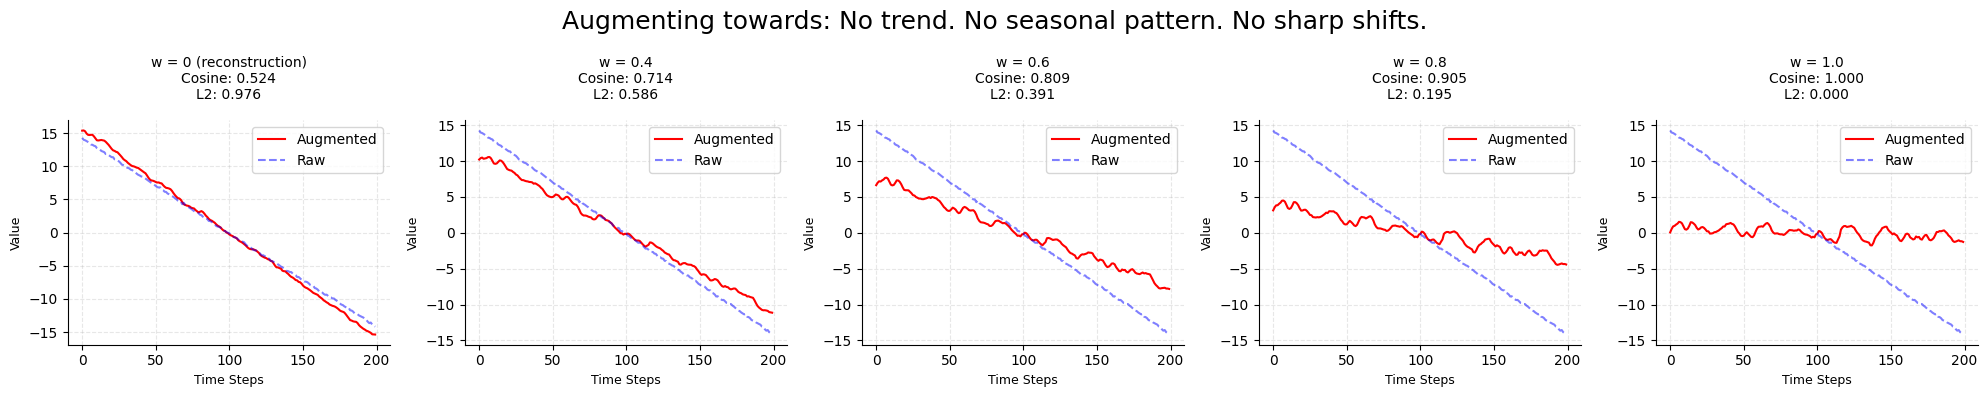

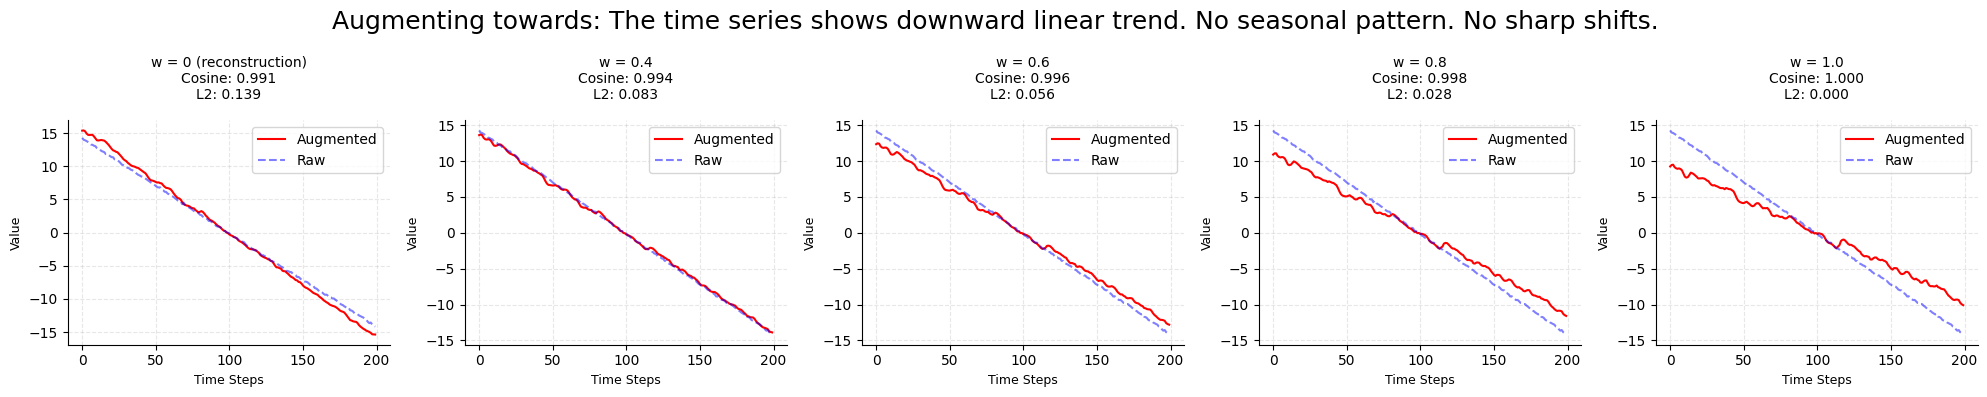

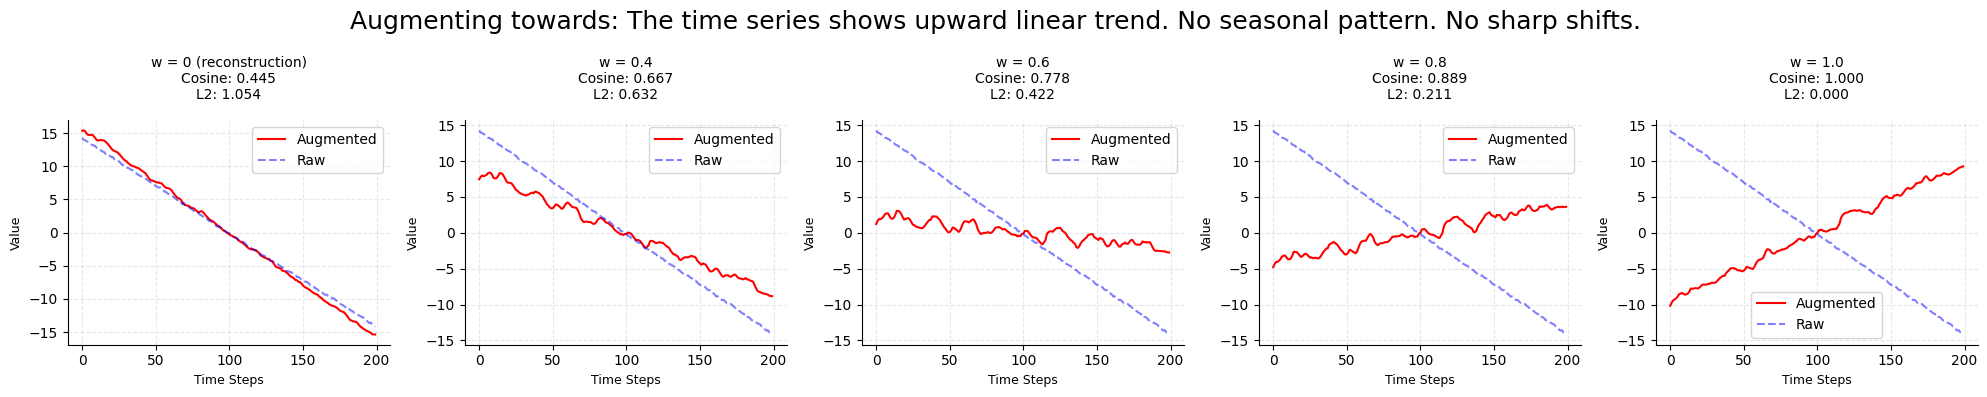

0    The time series shows upward linear trend.
Name: segment1, dtype: object


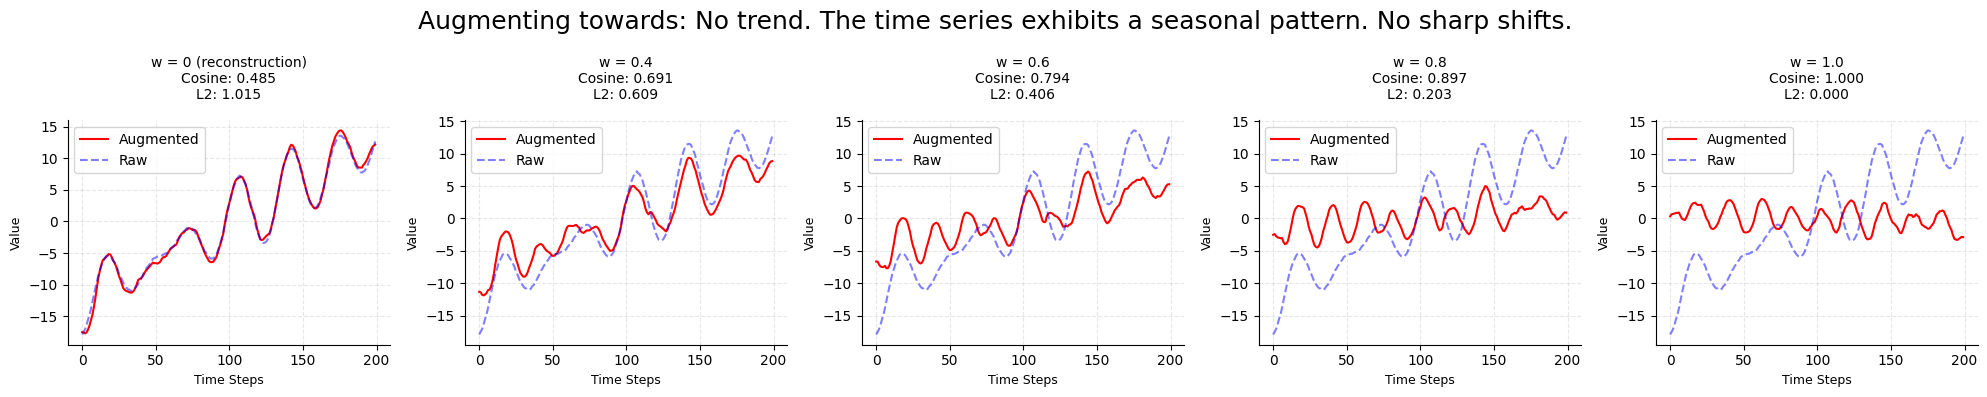

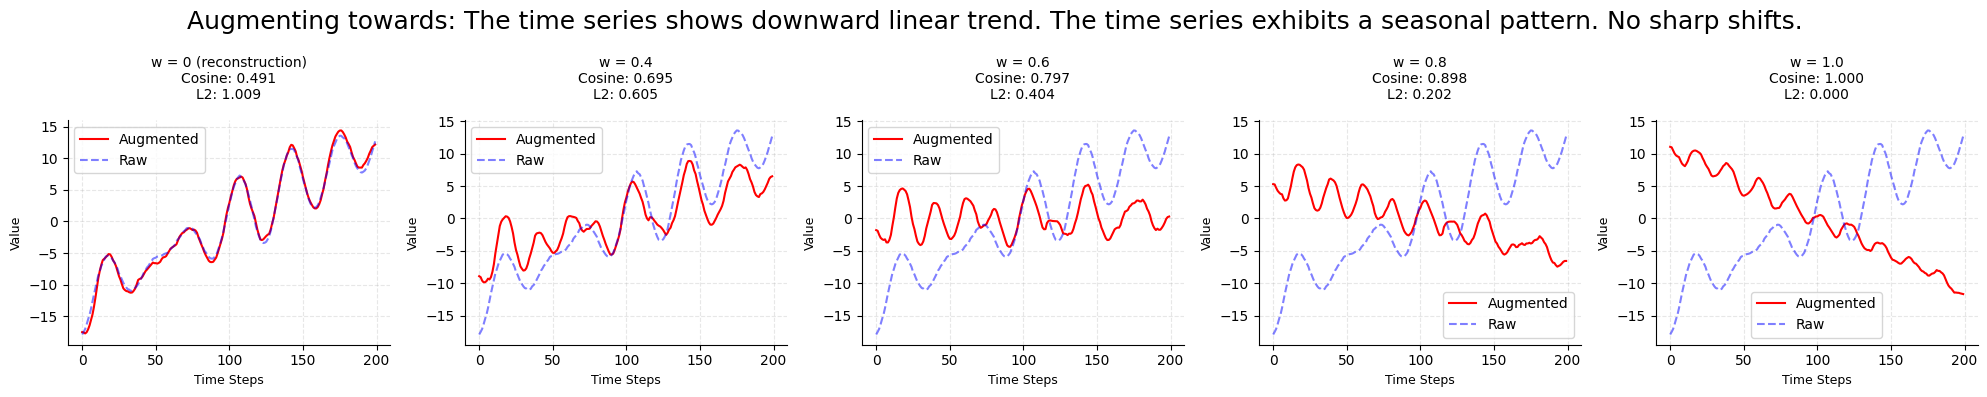

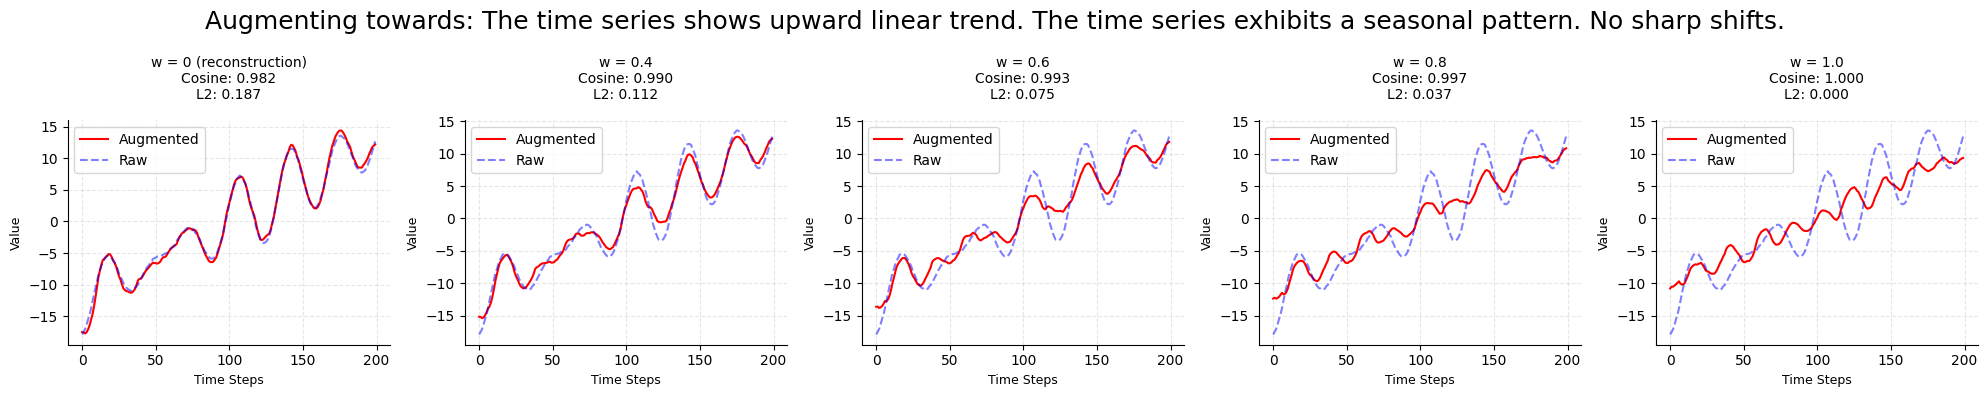

0    No seasonal pattern.
Name: segment2, dtype: object


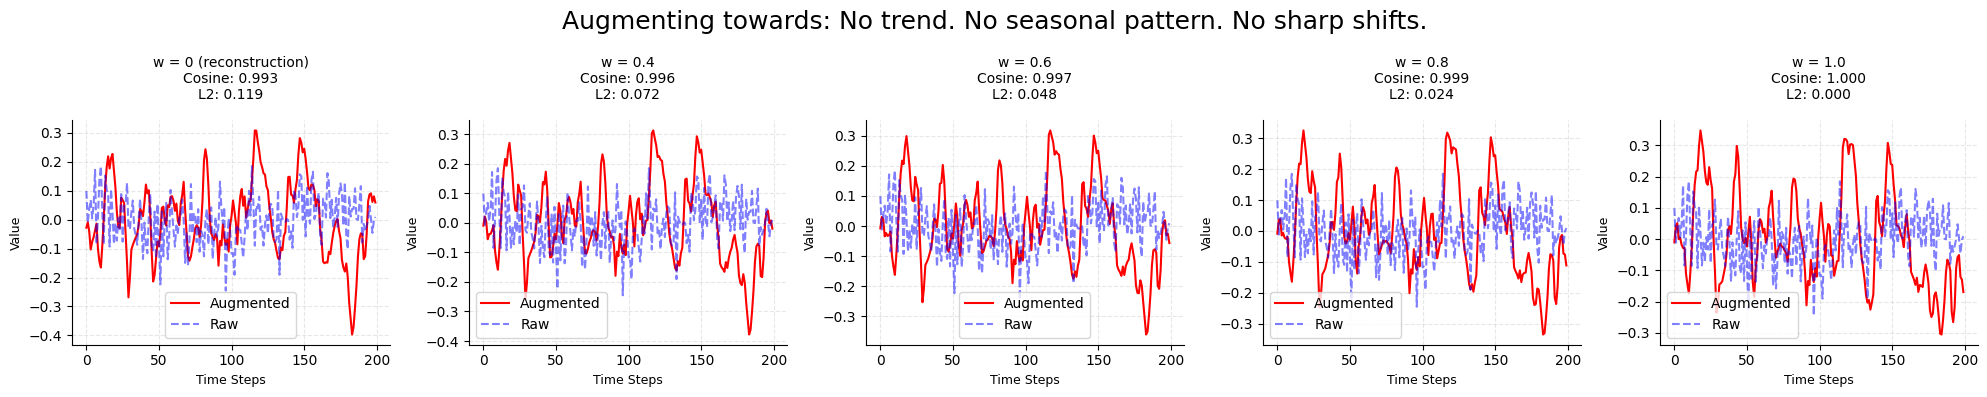

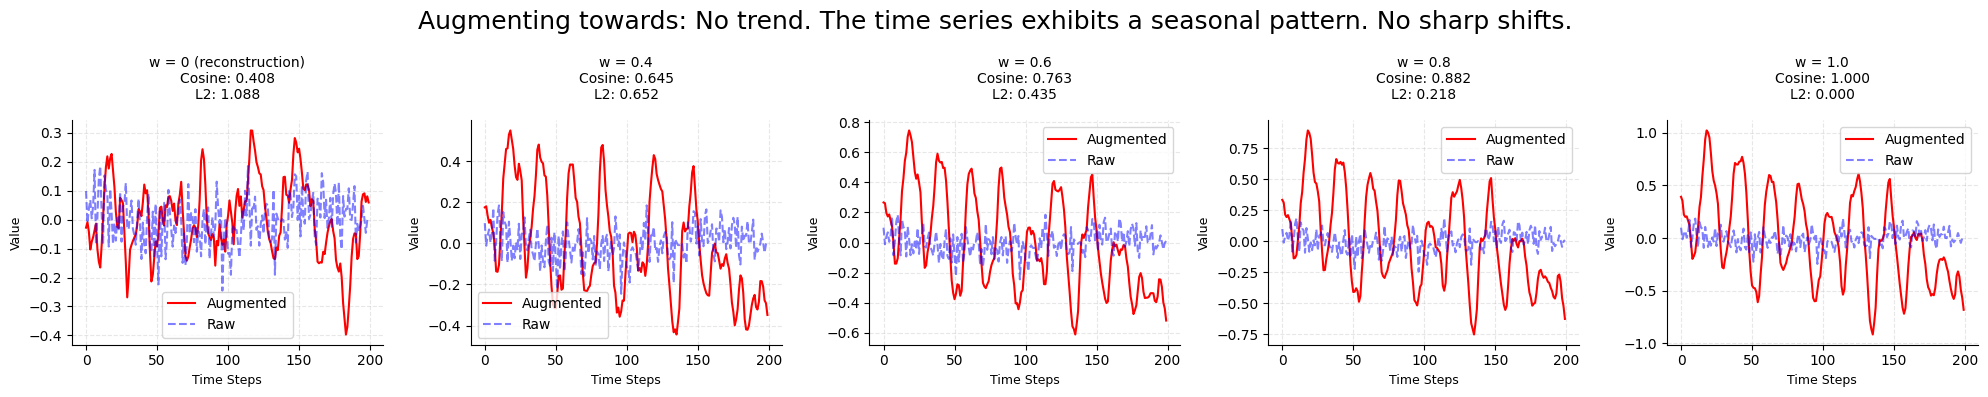

0    The time series exhibits a seasonal pattern.
Name: segment2, dtype: object


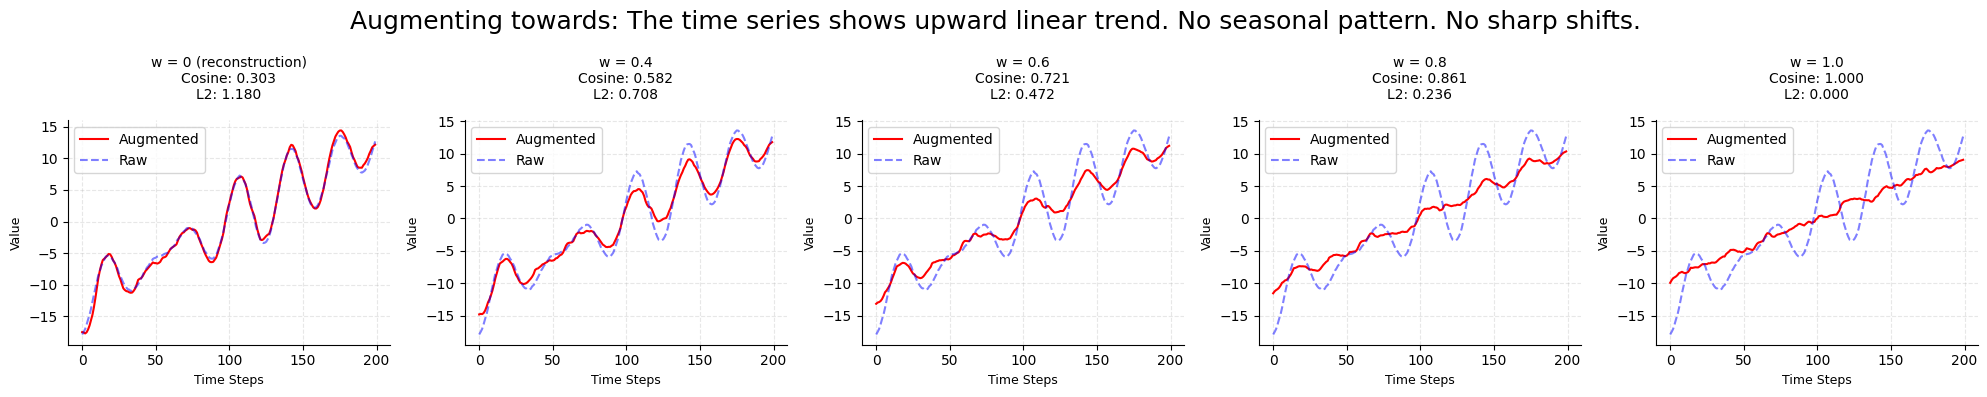

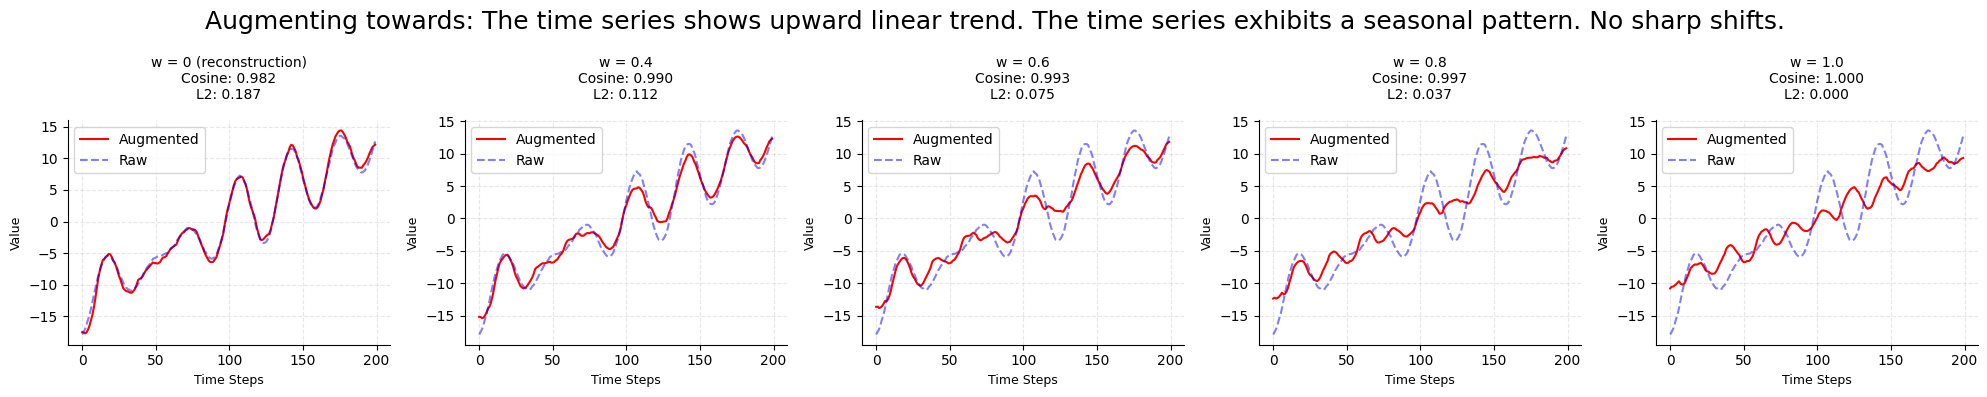

0    No sharp shifts.
Name: segment3, dtype: object


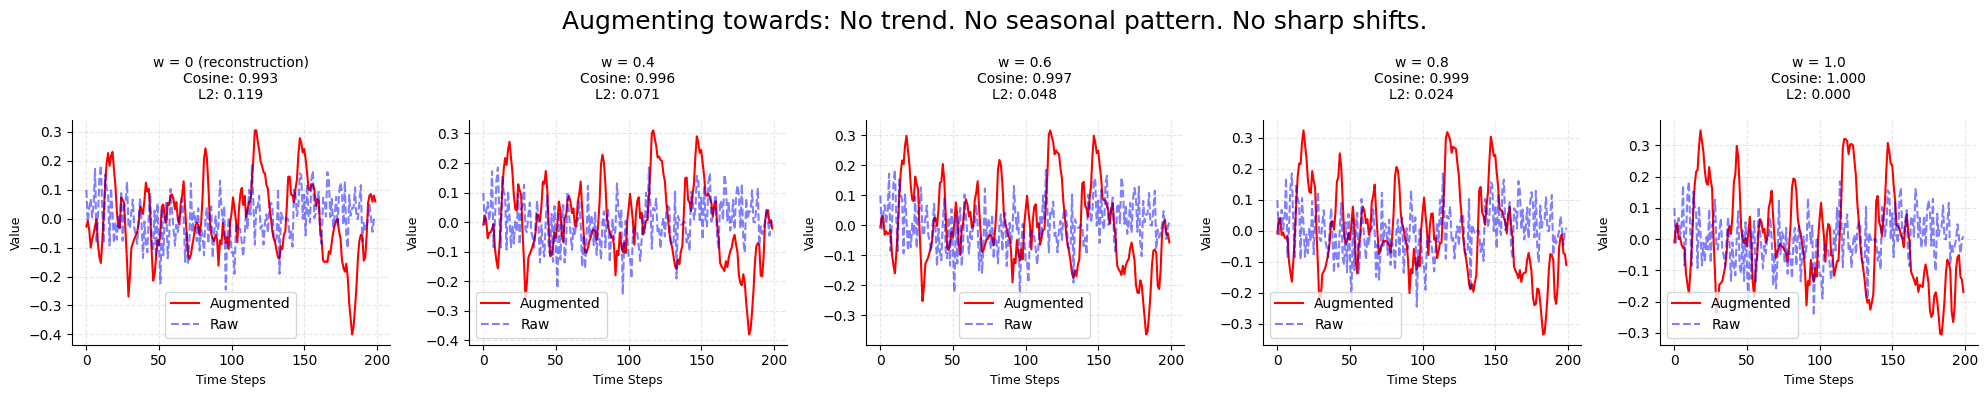

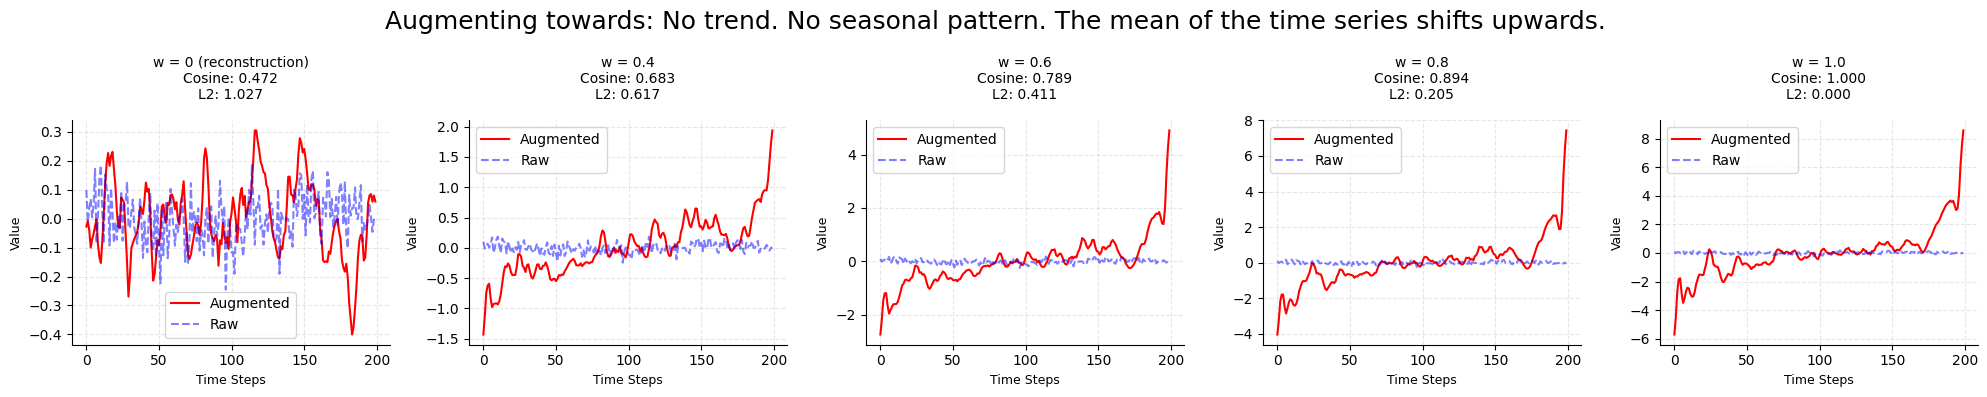

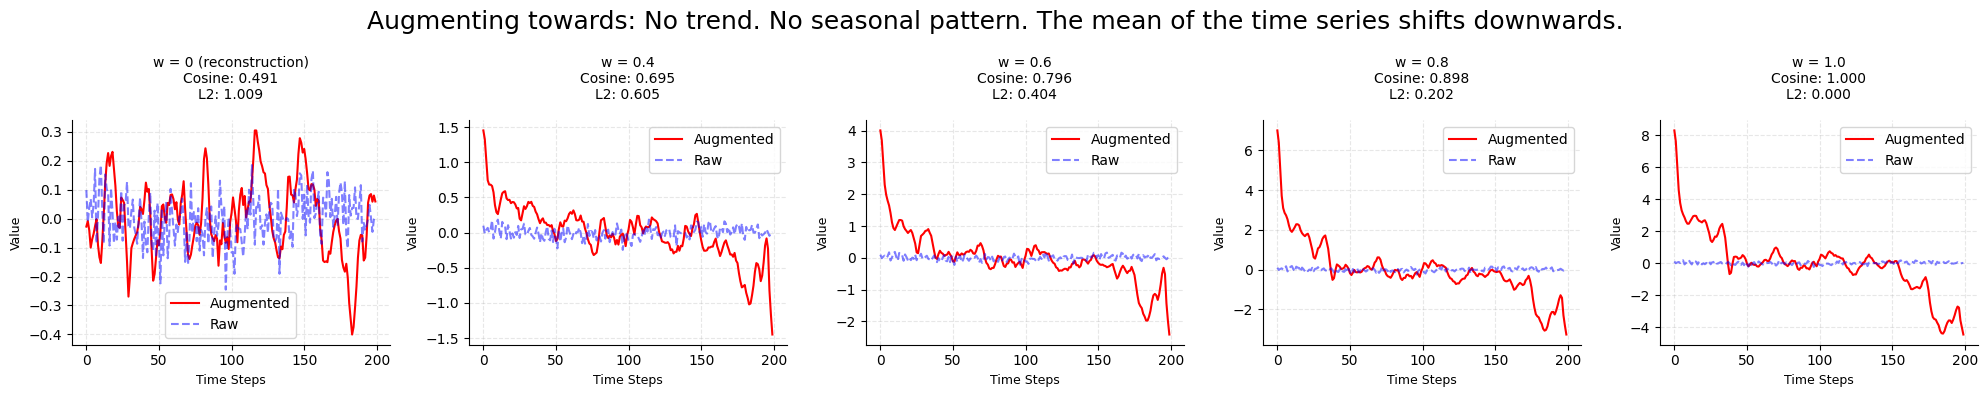

0    The mean of the time series shifts upwards.
Name: segment3, dtype: object


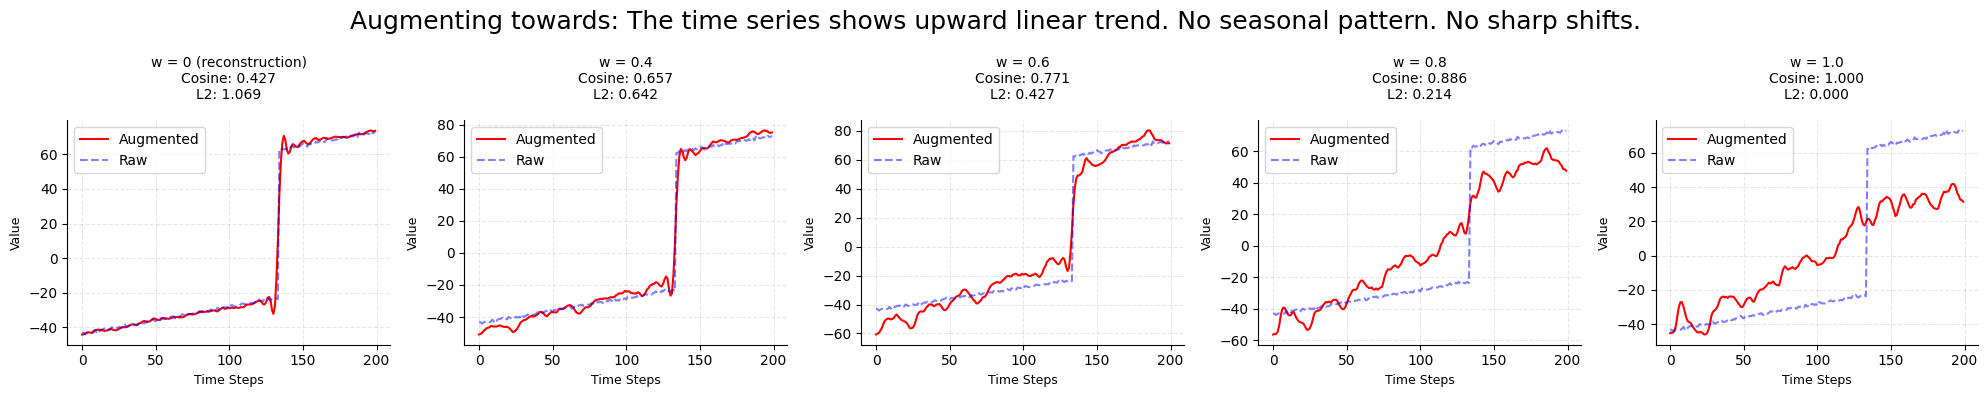

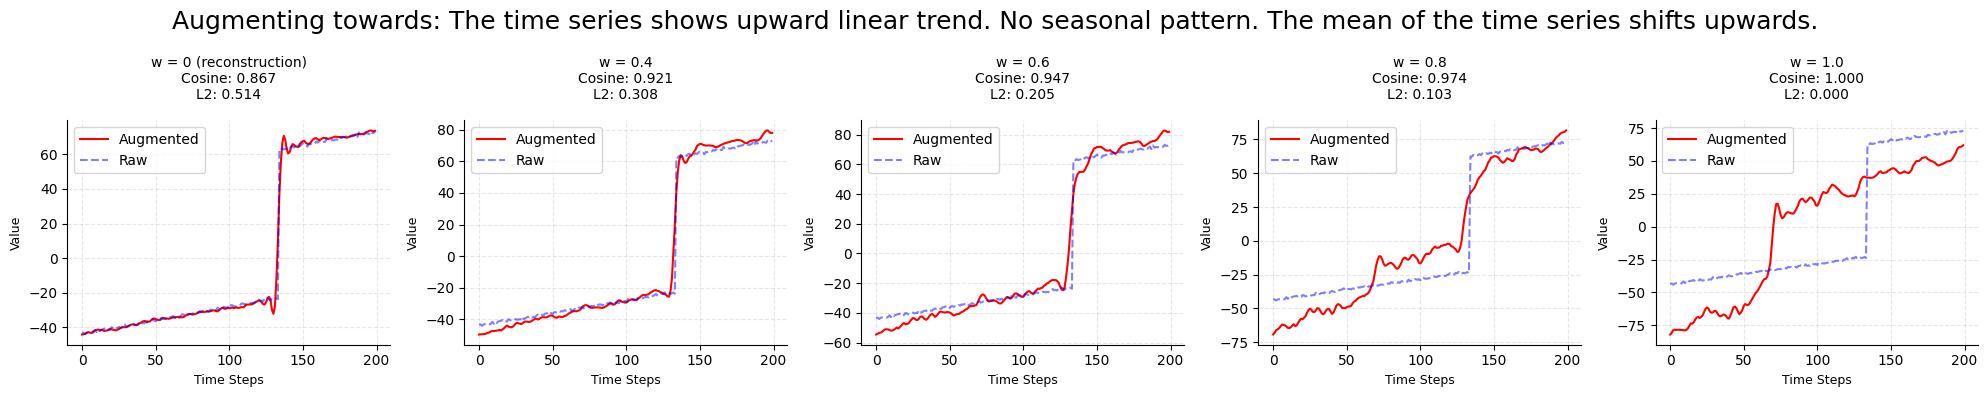

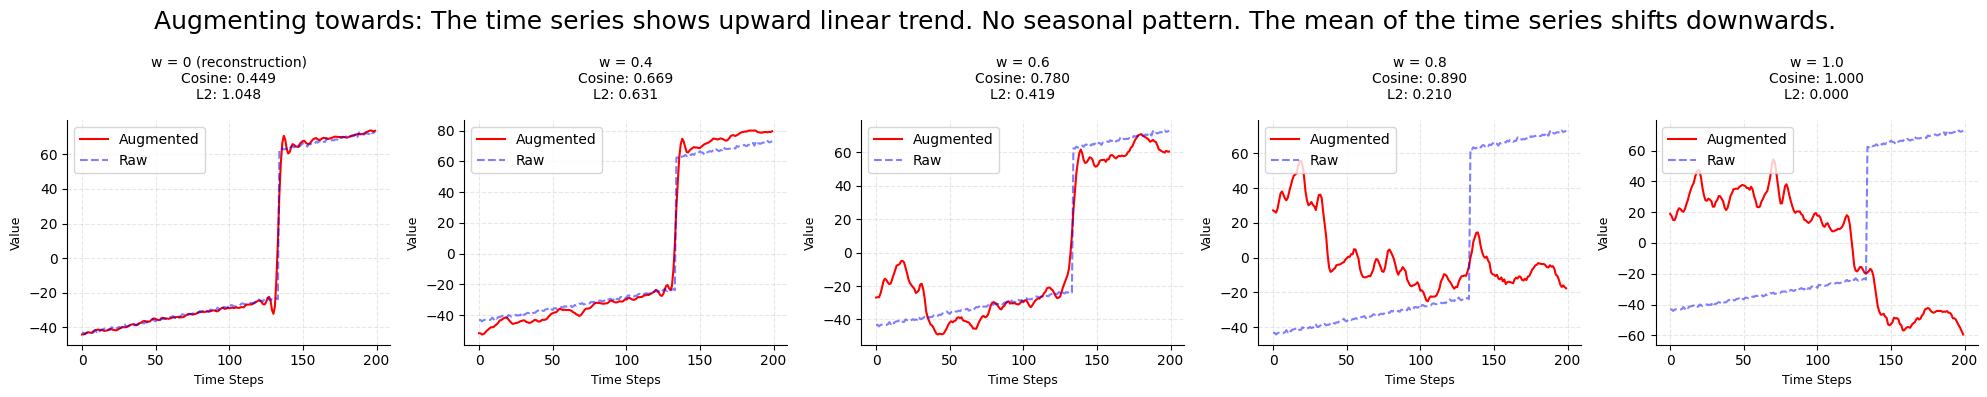

0    The mean of the time series shifts downwards.
Name: segment3, dtype: object


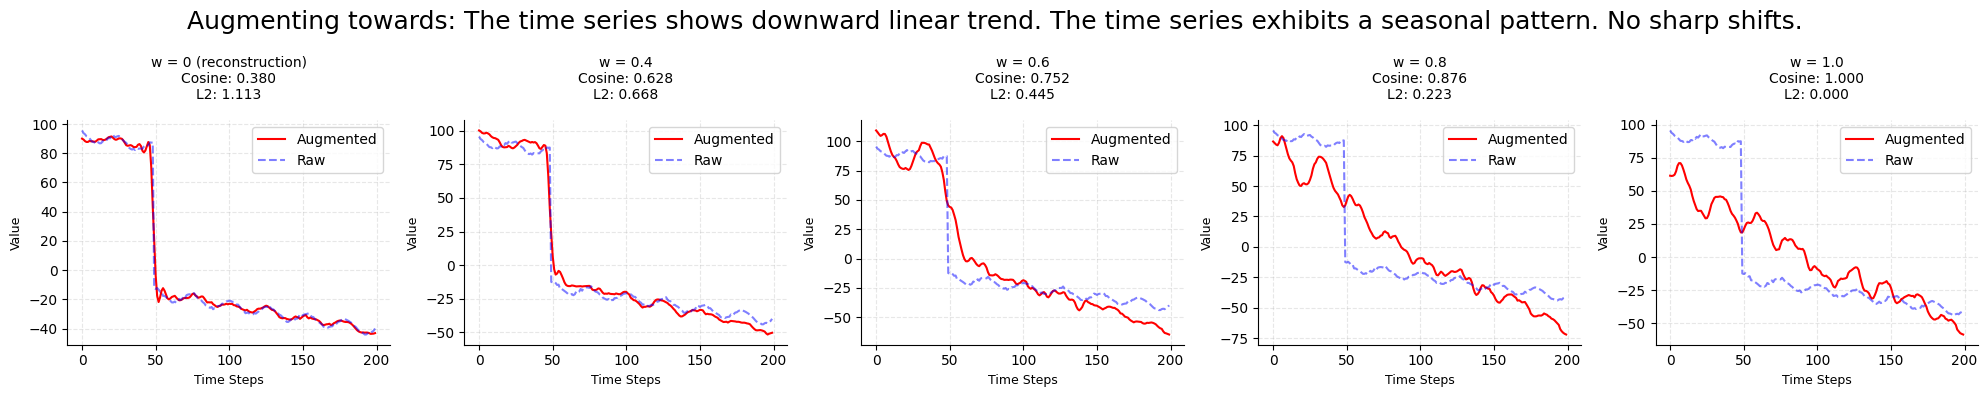

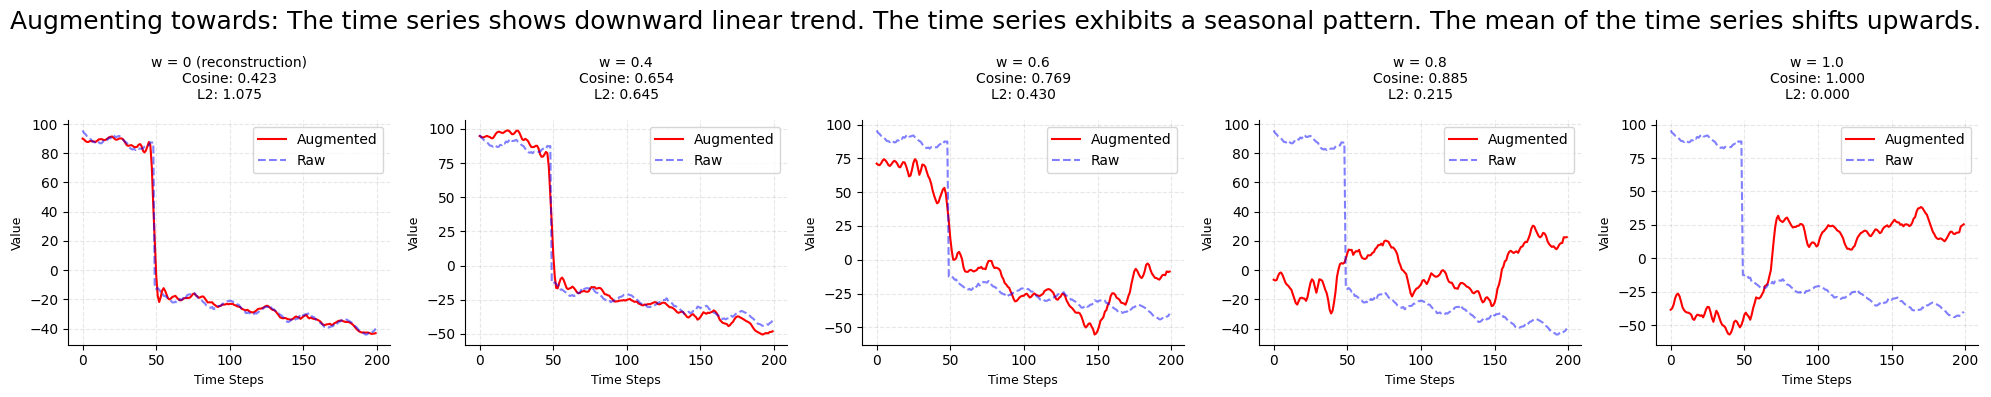

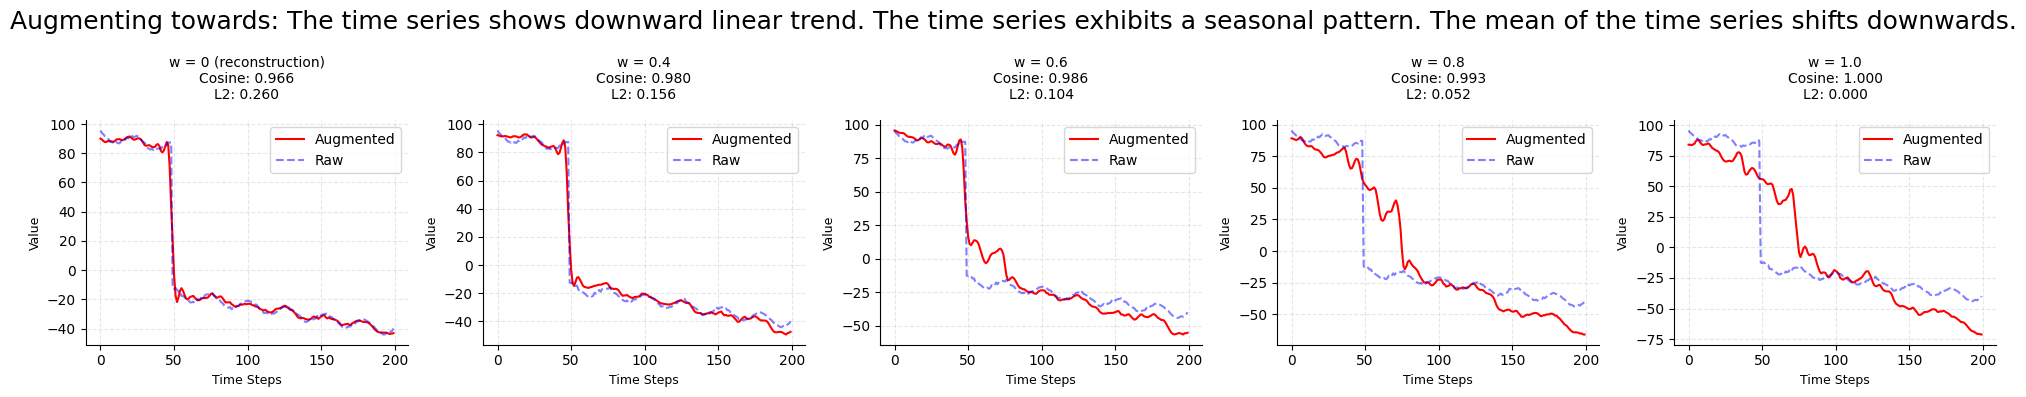

In [19]:
# overwrite = False
with open('run/train.py', 'r') as file:
    exec(file.read())


# Generation

In [ ]:
# visualize a single augmented time series
tid=0
viz_generation_marginal(df_train, model, config_dict, tid=tid)
viz_generation_conditional(df_train, model, config_dict, tid=tid)

In [ ]:
# calculate the properties of the generated time series
df = df_train.sample(1000)
df_augmented_all = eval_augmented_properties(df, model, config_dict, type = "conditional", w = 0.8)
# fig1, ax1, m1 = viz_augmented_properties(df_augmented_all, '', 'segment1')
# plt.show()

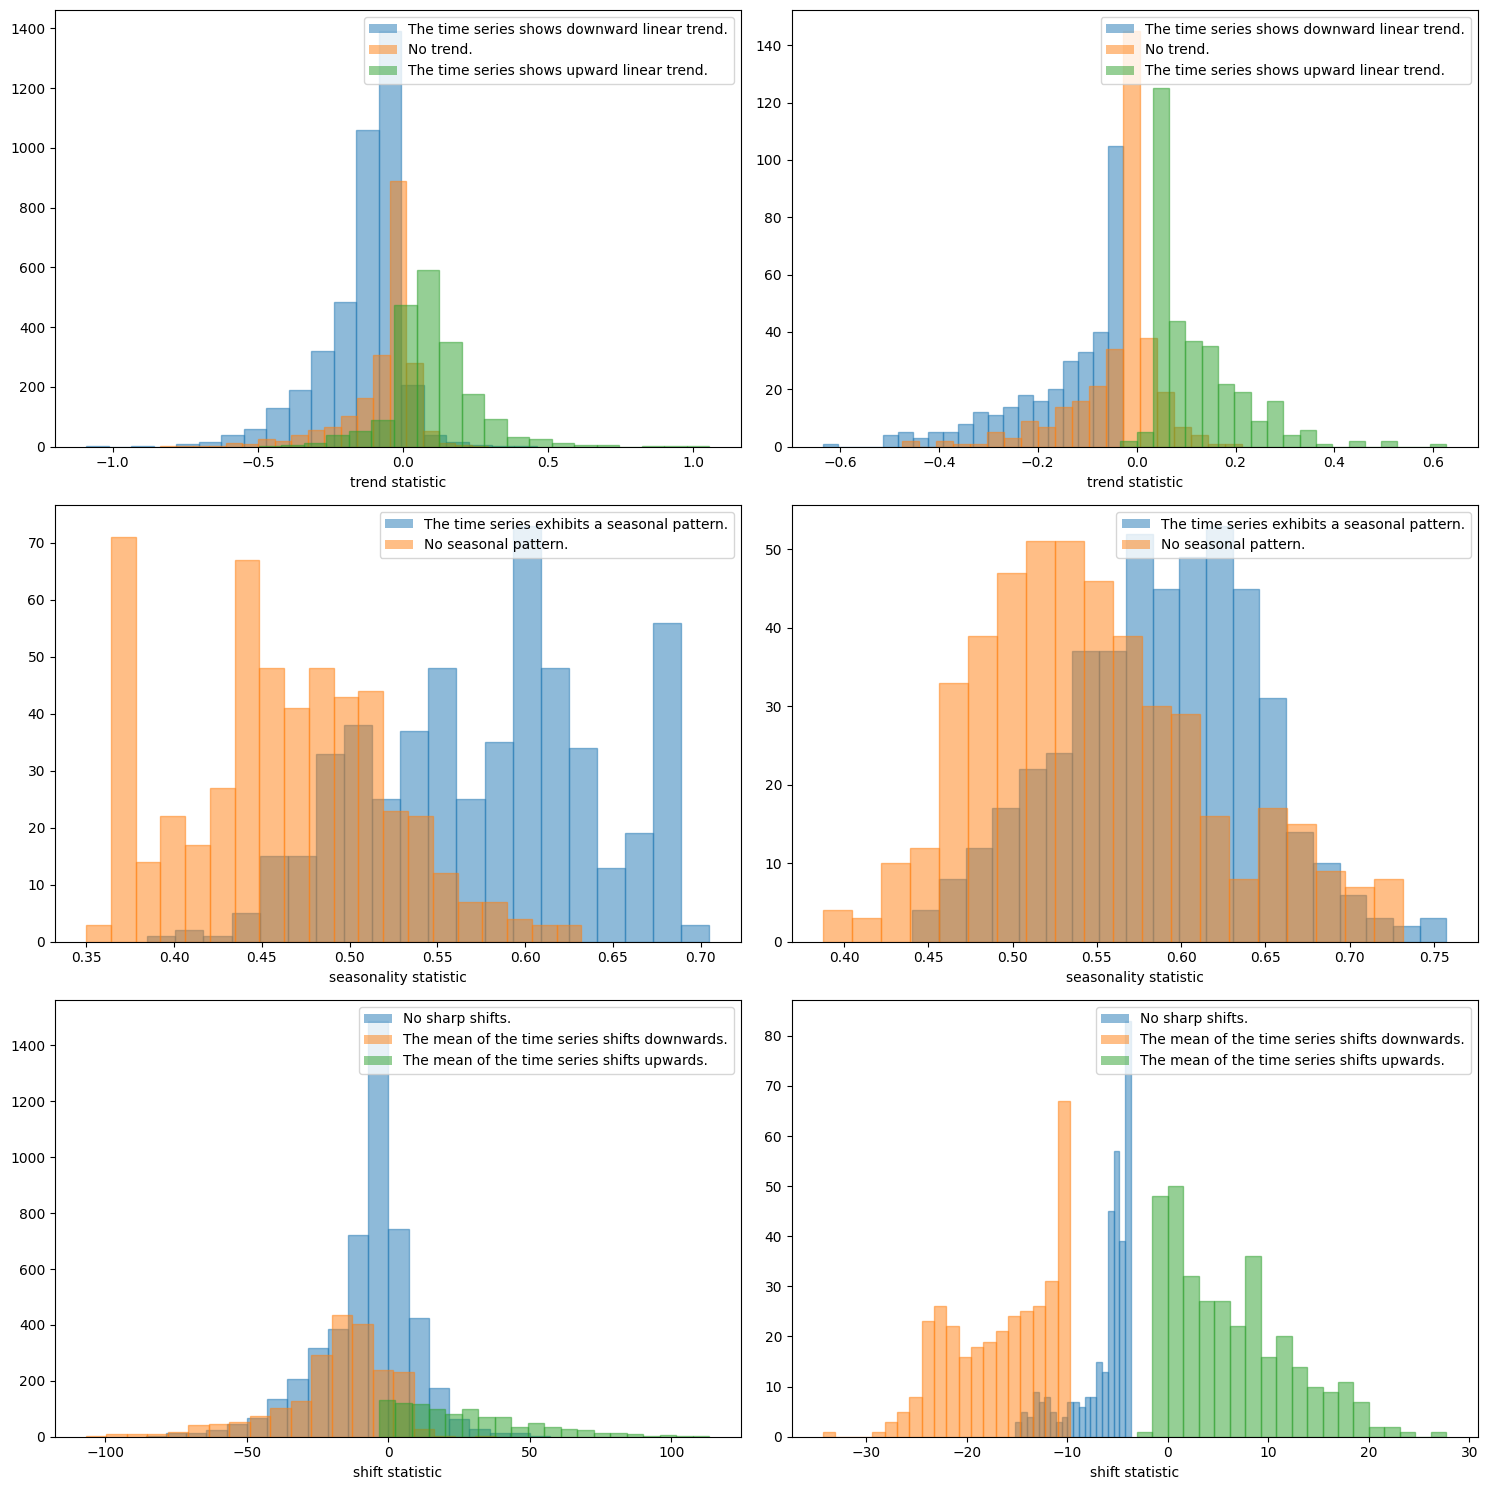

In [191]:
# Create lists to store figures and their metrics
figs = []
metrics = []

# Collect all plots
fig1, ax1, m1 = viz_augmented_properties(df_augmented_all, '', 'segment1')
fig2, ax2, m2 = viz_augmented_properties(df_augmented_all, 'No trend.', 'segment1')
fig3, ax3, m3 = viz_augmented_properties(df_augmented_all, 'No seasonal pattern.', 'segment2')
fig4, ax4, m4 = viz_augmented_properties(df_augmented_all, 'The time series exhibits a seasonal pattern.', 'segment2')
fig5, ax5, m5 = viz_augmented_properties(df_augmented_all, '', 'segment3')
fig6, ax6, m6 = viz_augmented_properties(df_augmented_all, 'No sharp shifts.', 'segment3')

figs.extend([fig1, fig2, fig3, fig4, fig5, fig6])
metrics.extend([m1, m2, m3, m4, m5, m6])

# Create combined figure with 3 rows
fig_combined, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns
axes = axes.flatten()  # Flatten to make indexing easier

# Copy content from individual figures to subplots
for i, (fig, metric) in enumerate(zip(figs, metrics)):
    src_ax = fig.axes[0]
    # Copy histogram patches and other plot elements
    for ax in fig.get_axes():
        for patch in ax.patches:
            axes[i].add_patch(plt.Rectangle((patch.get_x(), patch.get_y()), 
                                        patch.get_width(), patch.get_height(),
                                        alpha=patch.get_alpha(),
                                        color=patch.get_facecolor()))
        axes[i].set_xlim(ax.get_xlim())
        axes[i].set_ylim(ax.get_ylim())
    axes[i].set_xlabel(metric + ' statistic')
    handles, labels = src_ax.get_legend_handles_labels()
    axes[i].legend(handles, labels)
    plt.close(fig)  # Close individual figure to free memory

plt.tight_layout()
plt.show()

In [182]:
# calculate the properties of the generated time series
df = df_train.sample(1000)
df_augmented_all_marginal = eval_augmented_properties(df, model, config_dict, type = "marginal", w = 0.8)
# fig1, ax1, m1 = viz_augmented_properties(df_augmented_all, '', 'segment1')
# plt.show()

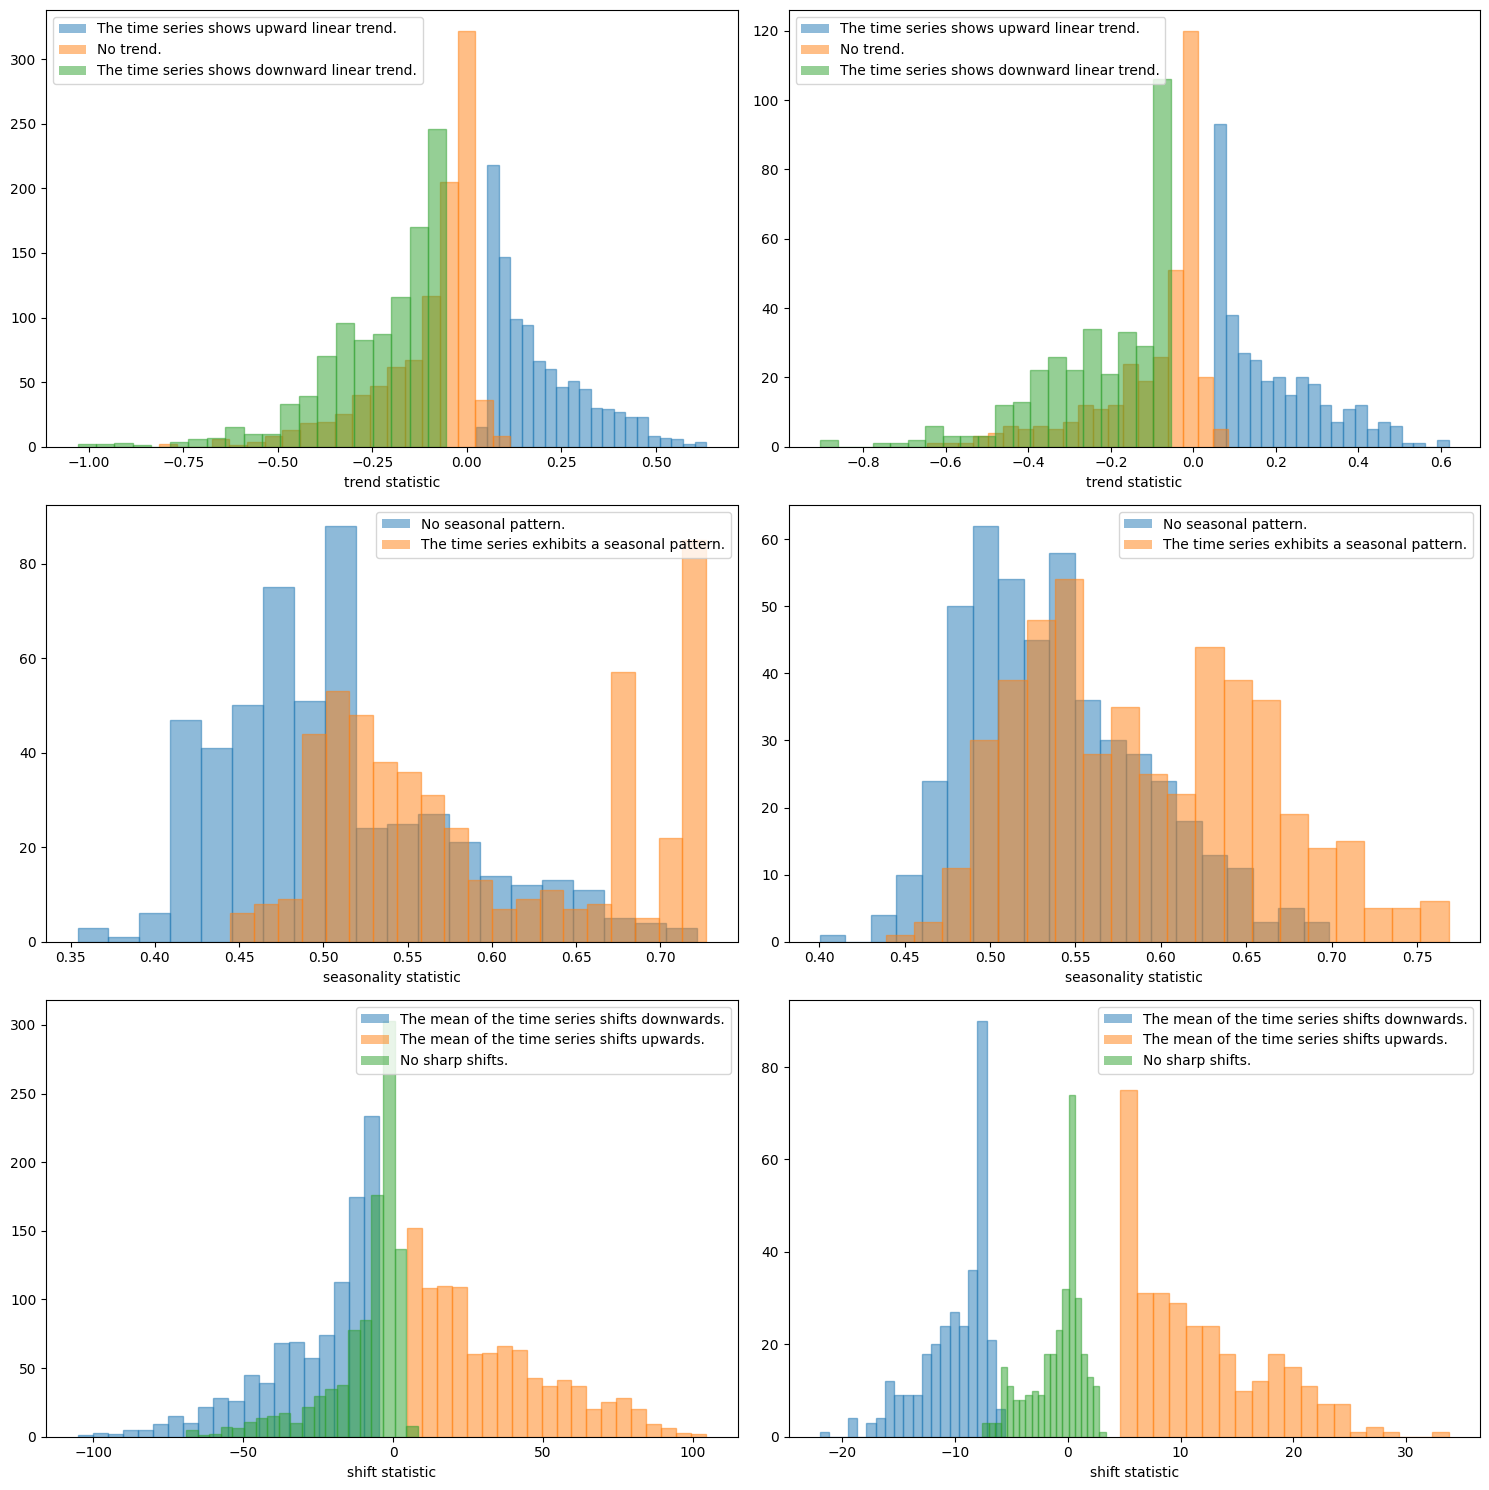

In [192]:
# Create lists to store figures and their metrics
figs = []
metrics = []

# Collect all plots
fig1, ax1, m1 = viz_augmented_properties(df_augmented_all_marginal, '', 'segment1')
fig2, ax2, m2 = viz_augmented_properties(df_augmented_all_marginal, 'No trend.', 'segment1')
fig3, ax3, m3 = viz_augmented_properties(df_augmented_all_marginal, 'No seasonal pattern.', 'segment2')
fig4, ax4, m4 = viz_augmented_properties(df_augmented_all_marginal, 'The time series exhibits a seasonal pattern.', 'segment2')
fig5, ax5, m5 = viz_augmented_properties(df_augmented_all_marginal, '', 'segment3')
fig6, ax6, m6 = viz_augmented_properties(df_augmented_all_marginal, 'No sharp shifts.', 'segment3')

figs.extend([fig1, fig2, fig3, fig4, fig5, fig6])
metrics.extend([m1, m2, m3, m4, m5, m6])

# Create combined figure with 3 rows
fig_combined, axes = plt.subplots(3, 2, figsize=(15, 15))  # 3 rows, 2 columns
axes = axes.flatten()  # Flatten to make indexing easier

# Copy content from individual figures to subplots
for i, (fig, metric) in enumerate(zip(figs, metrics)):
    src_ax = fig.axes[0]
    # Copy histogram patches and other plot elements
    for ax in fig.get_axes():
        for patch in ax.patches:
            axes[i].add_patch(plt.Rectangle((patch.get_x(), patch.get_y()), 
                                        patch.get_width(), patch.get_height(),
                                        alpha=patch.get_alpha(),
                                        color=patch.get_facecolor()))
        axes[i].set_xlim(ax.get_xlim())
        axes[i].set_ylim(ax.get_ylim())
    axes[i].set_xlabel(metric + ' statistic')
    handles, labels = src_ax.get_legend_handles_labels()
    axes[i].legend(handles, labels)
    plt.close(fig)  # Close individual figure to free memory

plt.tight_layout()
plt.show()